In [64]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time
from dateutil import relativedelta
from matplotlib import pyplot as plt
import seaborn as sns
from simply import redshift
from simply import simple_colors
from read_query_url import read_query
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.dates import date2num
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
new_brand_palette = ['#0D97FF', '#FD2B10', '#24D3C1', '#FFBA00', '#706AFE', '#FF9999', '#FF673D',  '#91D174', '#005DA4', '#98D3AE', '#F0D9A8', '#89EA29']
new_goals = sns.color_palette(palette=new_brand_palette)
sns.set_palette(new_goals)
sns.set_style('dark')
register_matplotlib_converters()

## Save results as CSV? (True/False)

In [2]:
#### Set this to True on 4th business day of the month
as_csv = True

## Run Charts from CSV? (True/False)

In [3]:
run_from_csv = False

In [4]:
# If running charts from a pre-existing CSV, add the date prefix for the files you want to use. 
# Example: for '2018-03-05_Total_Customers_Archive.csv', enter:
# prefix = '2018-03-05'

prefix = '2019-07-08' #only applicable if running from pre-existing csv

In [5]:
def dateparse(x):
    y, m, d = x.split('-')
    rd = date(int(y), int(m), int(d))
    return rd


# Revenue Drivers

## Balances

### Average & Median Daily Balance

In [6]:
adb_query = read_query('average_daily_balance.sql')

In [14]:
# Query on curated layer
if run_from_csv:
    adb = pd.read_csv("../output/{}_Monthly_ADB_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    adb['month'] = [dt.to_pydatetime().date() for dt in adb.month]
else:
    adb = redshift(adb_query)


In [15]:
# Save dataframe as CSV:
if as_csv:
    adb.to_csv("../output/{}_Monthly_ADB_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Monthly ADB results to CSV.')

Saved Monthly ADB results to CSV.


In [16]:
adb = adb[(adb.month >= date(2018,7,1)) & (adb.month < date(2019,10,1))]

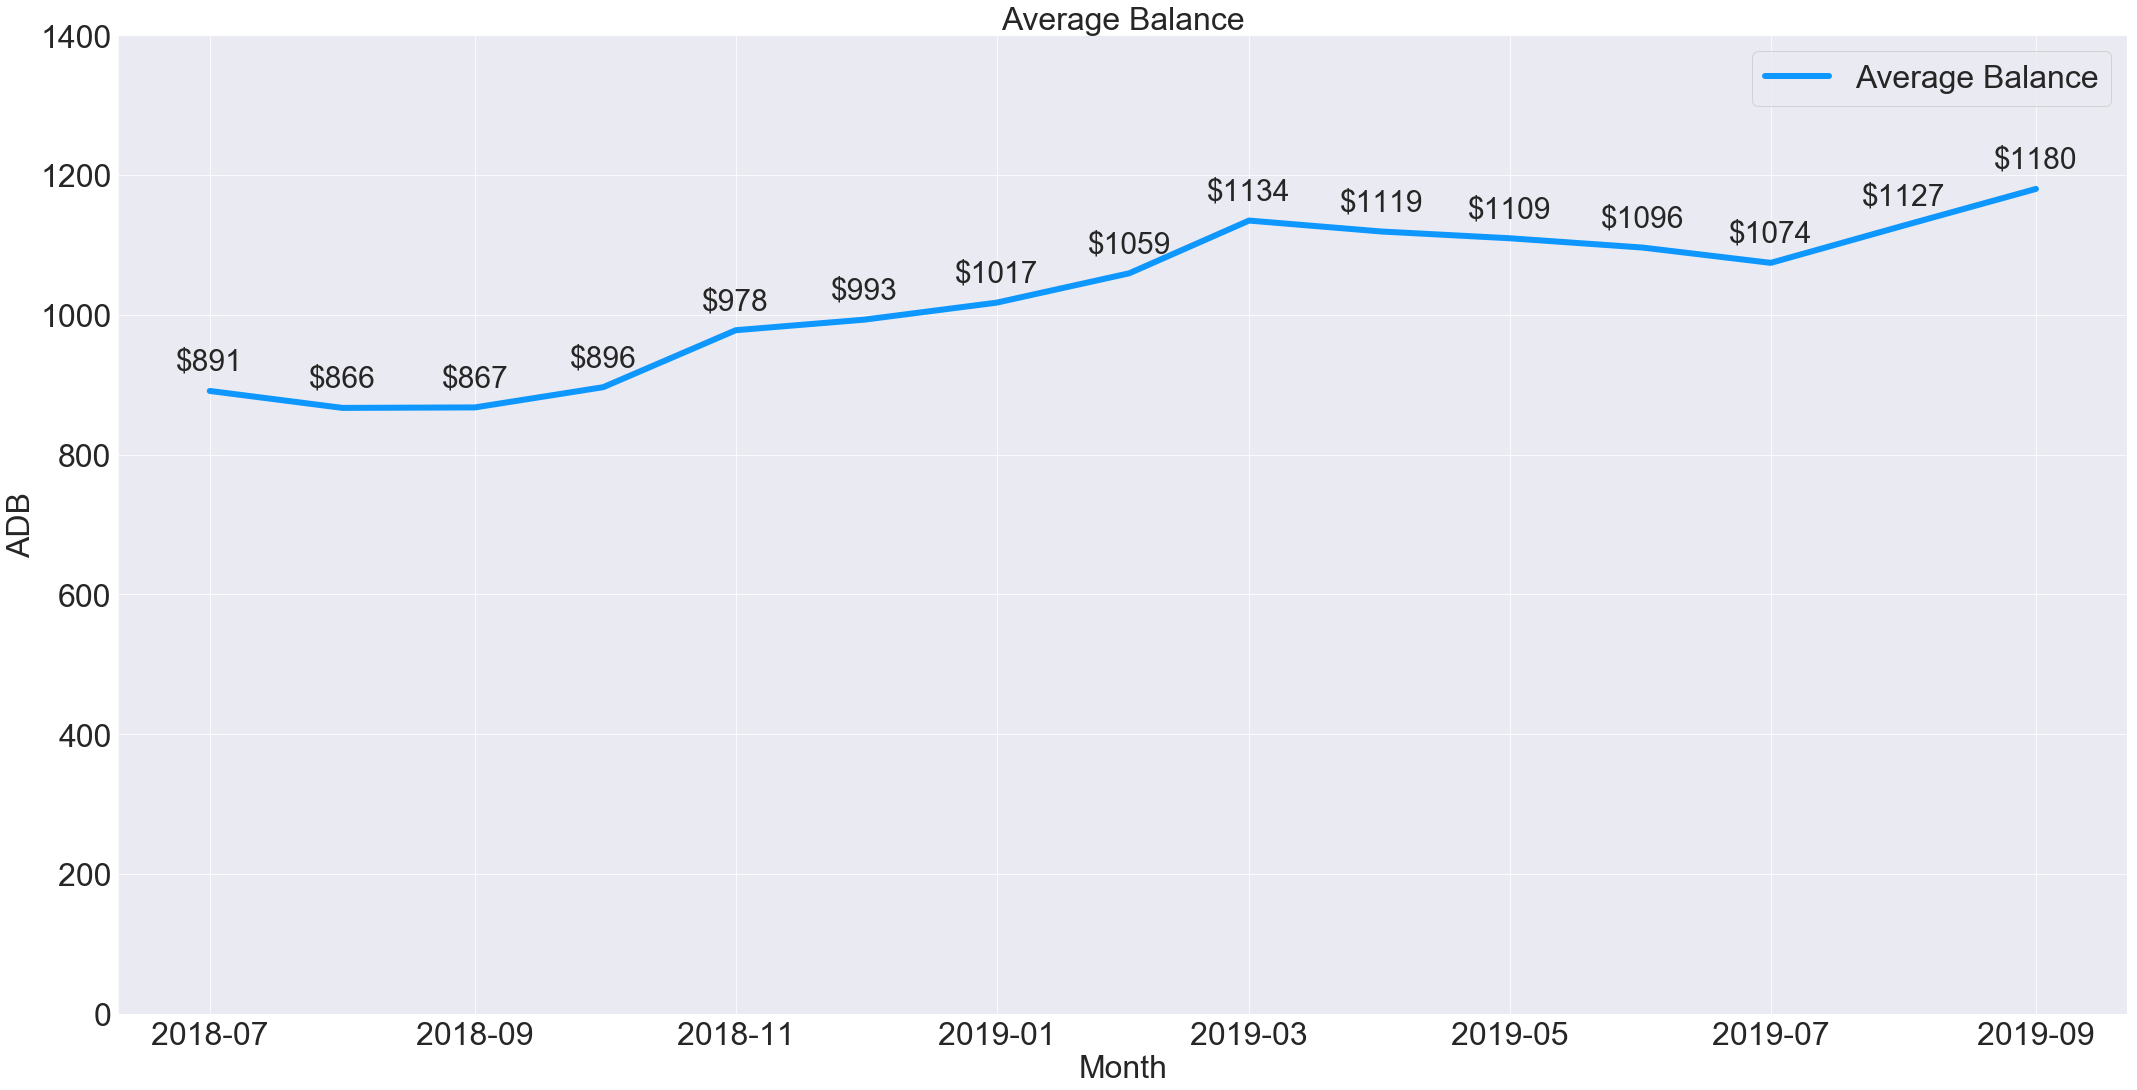

In [17]:
fig, ax = plt.subplots(figsize=(36,18))
ax.plot(adb.month, adb.average_balance, linewidth=6)
# ax.plot(adb.month, adb.median_balance, linewidth=6)
plt.xlabel('Month', fontsize=32)
plt.ylabel('ADB', fontsize=32)
plt.title('Average Balance', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylim(0,1400)
plt.grid(True)
plt.legend(['Average Balance'], fontsize=32)

for m in adb.month:
    plt.text(m, 
             adb[adb.month == m].average_balance+30, 
             '$'+str(int(adb[adb.month == m].average_balance)),
            fontsize=30,
            ha='center')
plt.savefig('../print_screen/{}_average_balance.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

### Average Balance by Yearly Cohort

In [18]:
# Defining months enrolled as 30 days (not calendar months)
adb_cohort_query = read_query('average_adb_by_monthly_yearly_cohort_30_day_definition.sql')

In [19]:
if run_from_csv:
    adb_cohort_data = pd.read_csv("../output/{}_Monthly_Yearly_Cohort_ADB_Archive.csv".format(prefix), index_col=0)
else:
    adb_cohort_data = redshift(adb_cohort_query)

In [20]:
adb_cohort_data.head()

,cohort_type,cohort,cohort_year,months_enrolled,adb,customers
0,month,2011-05-01,2011,0,75.000,1
1,month,2011-05-01,2011,1,64.221,1
2,month,2011-05-01,2011,2,11.439,1
3,month,2011-05-01,2011,3,48.414,1
4,month,2011-05-01,2011,4,33.474,1


In [21]:
# Save dataframe as CSV:
if as_csv:
    adb_cohort_data.to_csv("../output/{}_Monthly_Yearly_Cohort_ADB_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Monthly & Yearly Cohort ADB results to CSV.')

Saved Monthly & Yearly Cohort ADB results to CSV.


In [22]:
adb_yearly_cohort = adb_cohort_data[(adb_cohort_data.cohort_type == 'year')
                                    & (adb_cohort_data.cohort_year >= 2012)
                                    & (adb_cohort_data.months_enrolled <= 12)]

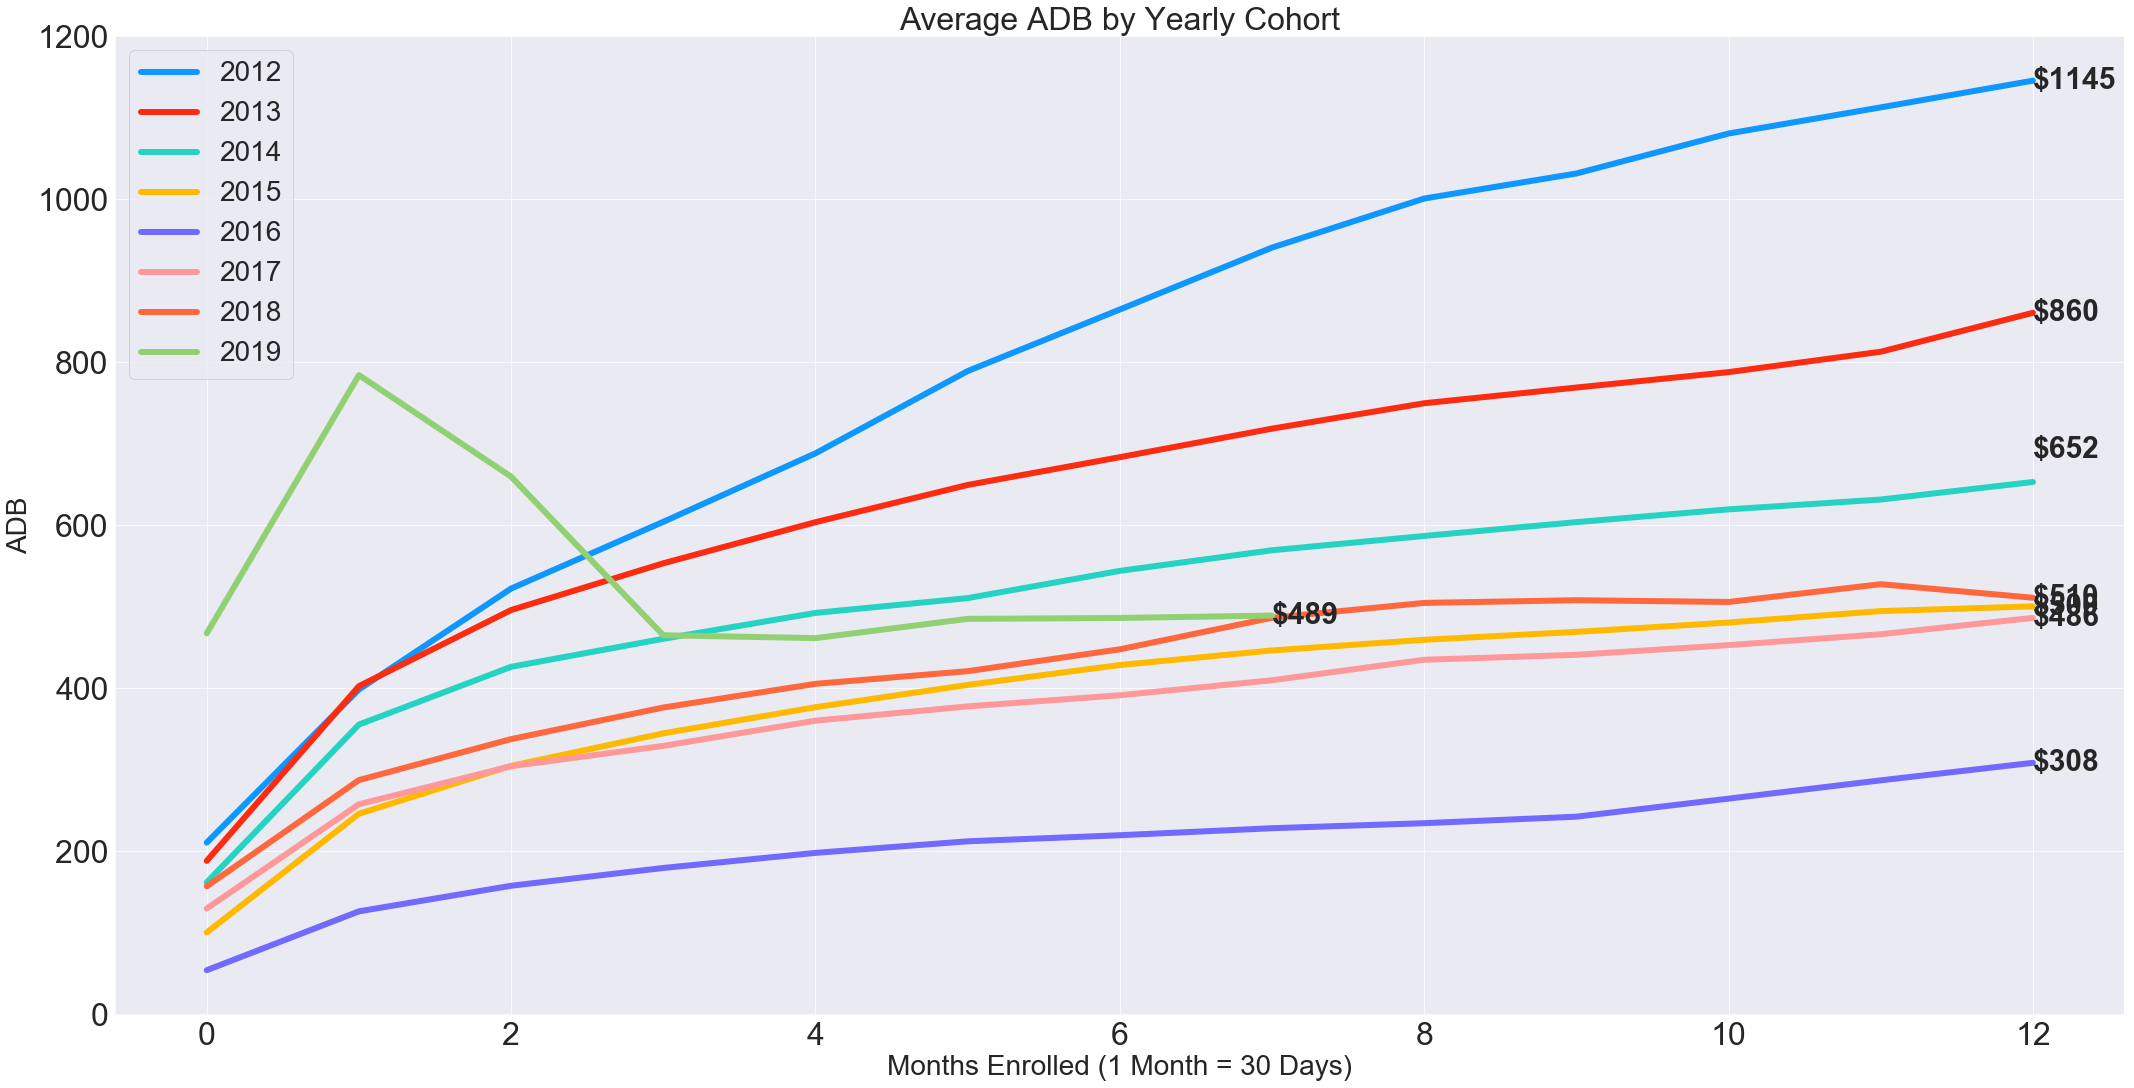

In [23]:
fig, ax = plt.subplots(figsize=(36,18))
l = adb_yearly_cohort.cohort_year.unique()
for x in l:
    d = adb_yearly_cohort[adb_yearly_cohort.cohort_year == x].copy()
    d = d[(d.months_enrolled <= 12) & (d.months_enrolled>=0)]
    ax.plot(d['months_enrolled'], d['adb'], linewidth=6)
plt.legend(l, loc=2, fontsize=28)
plt.xlabel('Months Enrolled (1 Month = 30 Days)', fontsize=28)
plt.ylabel('ADB', fontsize=28)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)
plt.title('Average ADB by Yearly Cohort', fontsize=32)

maxes = adb_yearly_cohort[['cohort_year', 'months_enrolled']].groupby('cohort_year', as_index=False).max()
for x in l:
    if x == 2014:
        max_val = int(maxes[maxes.cohort_year == x].months_enrolled)
        ax.text(adb_yearly_cohort[(adb_yearly_cohort.months_enrolled == max_val) & (adb_yearly_cohort.cohort_year == x)].months_enrolled,
                adb_yearly_cohort[(adb_yearly_cohort.months_enrolled == max_val) & (adb_yearly_cohort.cohort_year == x)].adb+30,
                '$'+str(int(adb_yearly_cohort[(adb_yearly_cohort.months_enrolled == max_val) & (adb_yearly_cohort.cohort_year == x)].adb)),
                fontsize=30,
                ha='left',
    #             backgroundcolor='white',
               weight='bold')
    else:
        max_val = int(maxes[maxes.cohort_year == x].months_enrolled)
        ax.text(adb_yearly_cohort[(adb_yearly_cohort.months_enrolled == max_val) & (adb_yearly_cohort.cohort_year == x)].months_enrolled,
                adb_yearly_cohort[(adb_yearly_cohort.months_enrolled == max_val) & (adb_yearly_cohort.cohort_year == x)].adb-10,
                '$'+str(int(adb_yearly_cohort[(adb_yearly_cohort.months_enrolled == max_val) & (adb_yearly_cohort.cohort_year == x)].adb)),
                fontsize=30,
                ha='left',
    #             backgroundcolor='white',
               weight='bold')
plt.savefig('../print_screen/{}_average_adb_by_yearly_cohort.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))

plt.show()

### Average Balance by Monthly Cohort

In [24]:
adb_monthly_cohort = adb_cohort_data[(adb_cohort_data.cohort_type == 'month')
                                    & (adb_cohort_data.cohort >= date(2019, 3, 1))]

In [25]:
adb_2012_cohort = adb_yearly_cohort[(adb_yearly_cohort.cohort_year == 2012)
                                    & (adb_yearly_cohort.months_enrolled <= 6)]

In [26]:
adb_monthly_cohort.cohort.unique()

array([datetime.date(2019, 3, 1), datetime.date(2019, 4, 1),
       datetime.date(2019, 5, 1), datetime.date(2019, 6, 1),
       datetime.date(2019, 7, 1), datetime.date(2019, 8, 1)], dtype=object)

In [27]:
adb_monthly_cohort[['cohort', 'months_enrolled']].groupby('cohort', as_index=False).max()

,cohort,months_enrolled
0,2019-03-01,5
1,2019-04-01,4
2,2019-05-01,3
3,2019-06-01,2
4,2019-07-01,1
5,2019-08-01,0


In [28]:
l = list(adb_monthly_cohort.cohort.unique())
maxes = adb_monthly_cohort[['cohort', 'months_enrolled']].groupby('cohort', as_index=False).max()

for x in l:
    print(int(maxes[maxes.cohort == x].months_enrolled))

5
4
3
2
1
0


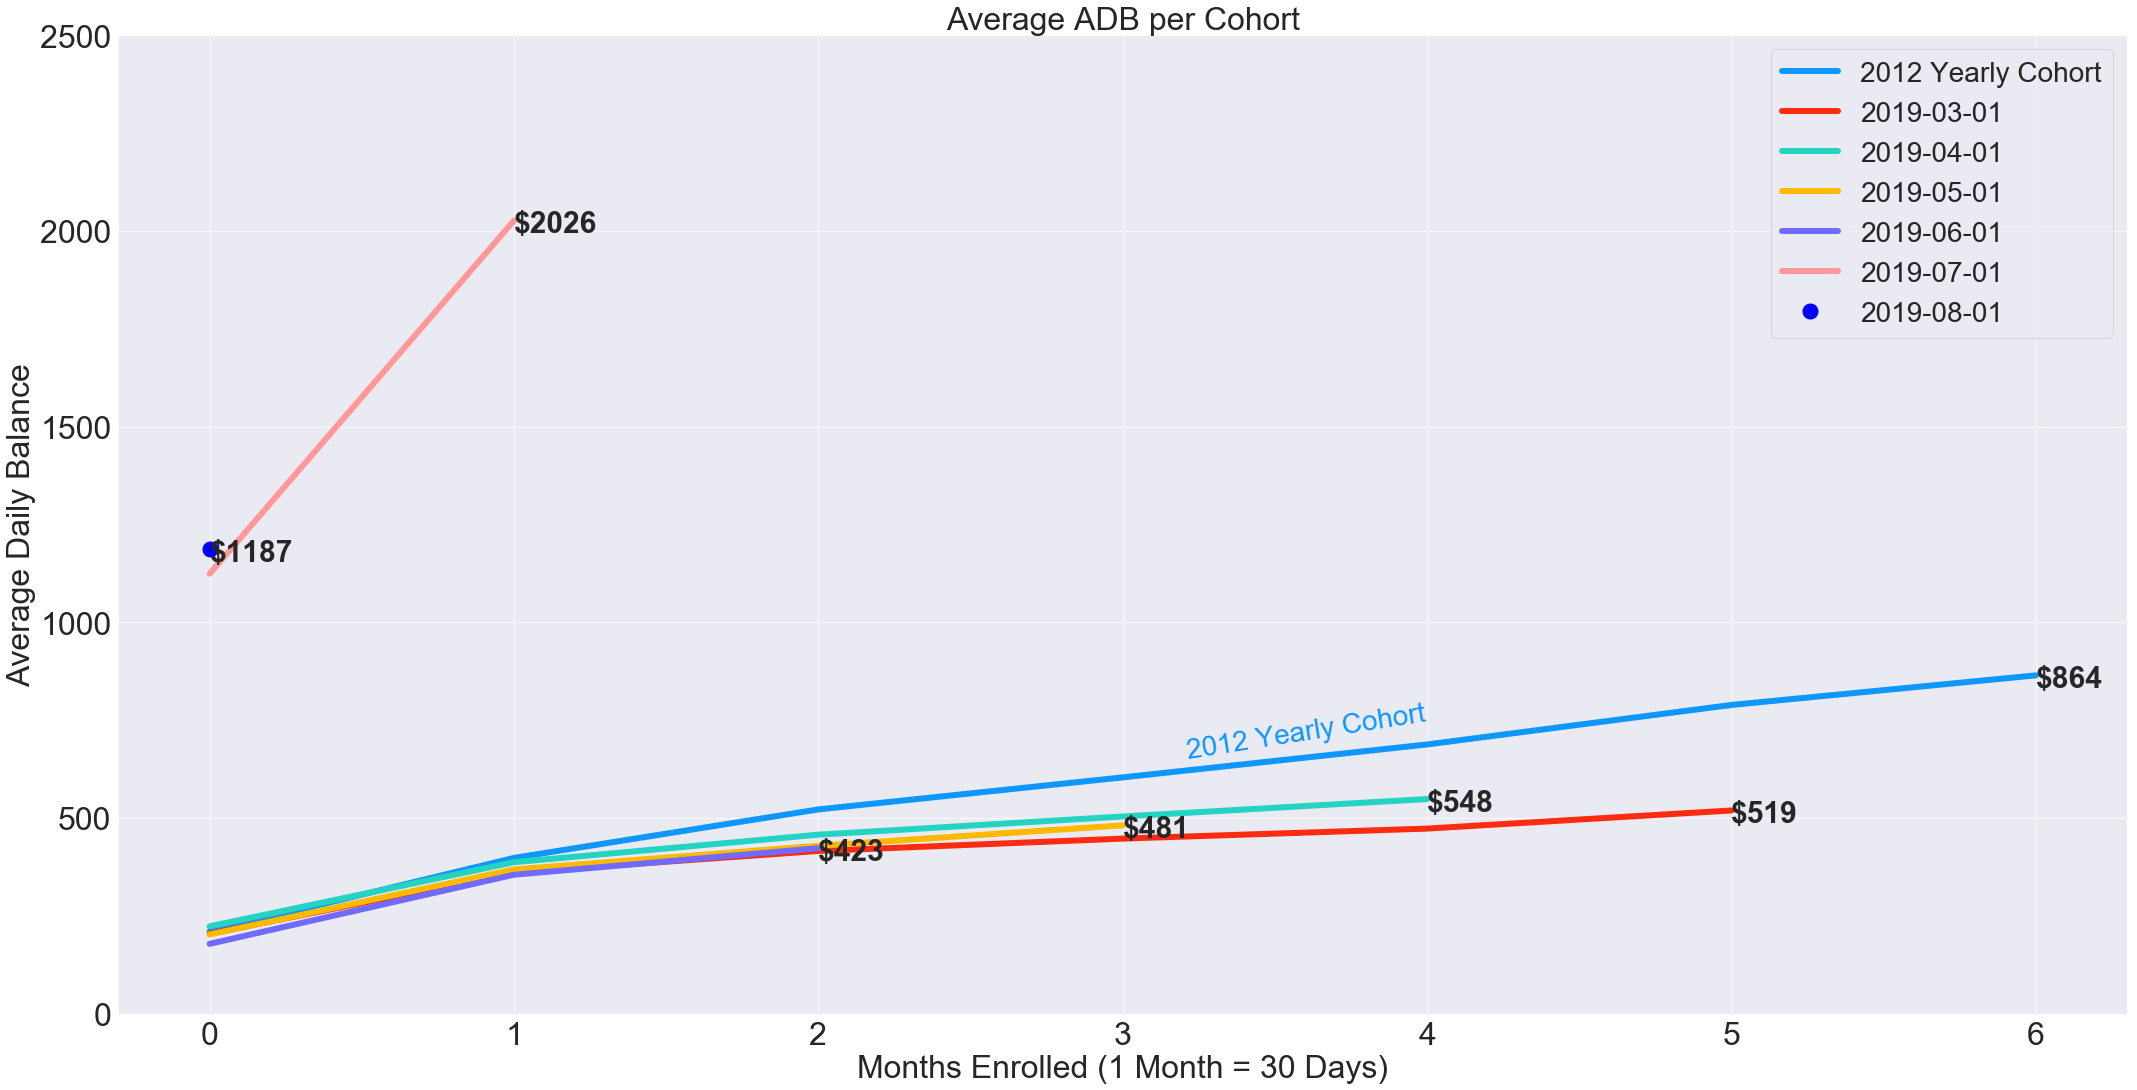

In [29]:
fig, ax = plt.subplots(figsize=(36,18))
ax.plot(adb_2012_cohort.months_enrolled, adb_2012_cohort.adb, linewidth=6)
l = list(adb_monthly_cohort.cohort.unique())
# l = balances_cohort.cohort.unique()
last_month = adb_monthly_cohort.cohort.max()
# last_month = date(date.today().year, date.today().month, 1) + relativedelta.relativedelta(months=-1)

for x in l:
    d = adb_monthly_cohort[adb_monthly_cohort.cohort == x].copy()
    d = d[(d.months_enrolled <= 24) & (d.months_enrolled >= 0)]
    if x == last_month:
        ax.plot(d['months_enrolled'], d['adb'], 'bo', ms=15)
    else:
        ax.plot(d['months_enrolled'], d['adb'], linewidth=6)
l.insert(0, '2012 Yearly Cohort')
# plt.legend(l, loc=2, fontsize=28)
plt.xlabel('Months Enrolled (1 Month = 30 Days)', fontsize=32)
plt.ylabel('Average Daily Balance', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylim(0,2500) #900)
plt.title('Average ADB per Cohort', fontsize=32)
plt.legend(l, loc=1, fontsize=28)
plt.text(4, 750, '2012 Yearly Cohort', ha='right', fontsize=28, color='#0D97FF', rotation=9.0)
plt.grid(True)
#plt.text(5.5, 433, 'August 2017', fontsize=28, ha='center', rotation=12, color='#FD2B10')
#plt.text(4.5, 480, 'September 2017', fontsize=28, ha='center', rotation=18, color='#24D3C1')
#plt.text(2.5, 385, 'November 2017', fontsize=28, ha='center', rotation=11, color='#706AFE')
#plt.text(0, 40, '{} 2018'.format(last_month.strftime('%B')), fontsize=28, color='b')

maxes = adb_monthly_cohort[['cohort', 'months_enrolled']].groupby('cohort', as_index=False).max()

for x in adb_monthly_cohort.cohort.unique():
    max_val = int(maxes[maxes.cohort == x].months_enrolled)
    ax.text(adb_monthly_cohort[(adb_monthly_cohort.months_enrolled == max_val) & (adb_monthly_cohort.cohort == x)].months_enrolled,
        adb_monthly_cohort[(adb_monthly_cohort.months_enrolled == max_val) & (adb_monthly_cohort.cohort == x)].adb-30,
        '$'+str(int(adb_monthly_cohort[(adb_monthly_cohort.months_enrolled == max_val) & (adb_monthly_cohort.cohort == x)].adb)),
        fontsize=30,
        ha='left',
    #             backgroundcolor='white',
       weight='bold')

maxes_12 = adb_2012_cohort[['cohort_year', 'months_enrolled']].groupby('cohort_year', as_index=False).max()

for y in adb_2012_cohort.cohort_year.unique():
    max_val_12 = int(maxes_12[maxes_12.cohort_year == y].months_enrolled)
    ax.text(adb_2012_cohort[(adb_2012_cohort.months_enrolled == max_val_12) & (adb_2012_cohort.cohort_year == y)].months_enrolled,
        adb_2012_cohort[(adb_2012_cohort.months_enrolled == max_val_12) & (adb_2012_cohort.cohort_year == y)].adb-30,
        '$'+str(int(adb_2012_cohort[(adb_2012_cohort.months_enrolled == max_val_12) & (adb_2012_cohort.cohort_year == y)].adb)),
        fontsize=30,
        ha='left',
    #             backgroundcolor='white',
       weight='bold')
    
plt.savefig('../print_screen/{}_average_adb_by_monthly_cohort.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))


plt.show()

## Swipes

### Average & Median Swipe Count

In [30]:
swipes_after_2012 = read_query('norm_avg_swipes_monthly.sql')

In [31]:
if run_from_csv:
    swipes_after_2012 = pd.read_csv("../output/{}_Average_Swipes_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    swipes_after_2012['month'] = [dt.to_pydatetime().date() for dt in swipes_after_2012.month]
else:
    swipes_after_2012 = redshift(swipes_after_2012)
    


In [32]:
# Save dataframe as CSV:
if as_csv:
    swipes_after_2012.to_csv("../output/{}_Average_Swipes_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Average Swipes results to CSV.')

Saved Average Swipes results to CSV.


In [33]:
swipes_after_2012 = swipes_after_2012[(swipes_after_2012.month >= date(2018,7,1)) & (swipes_after_2012.month < date(2019,10,1))]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


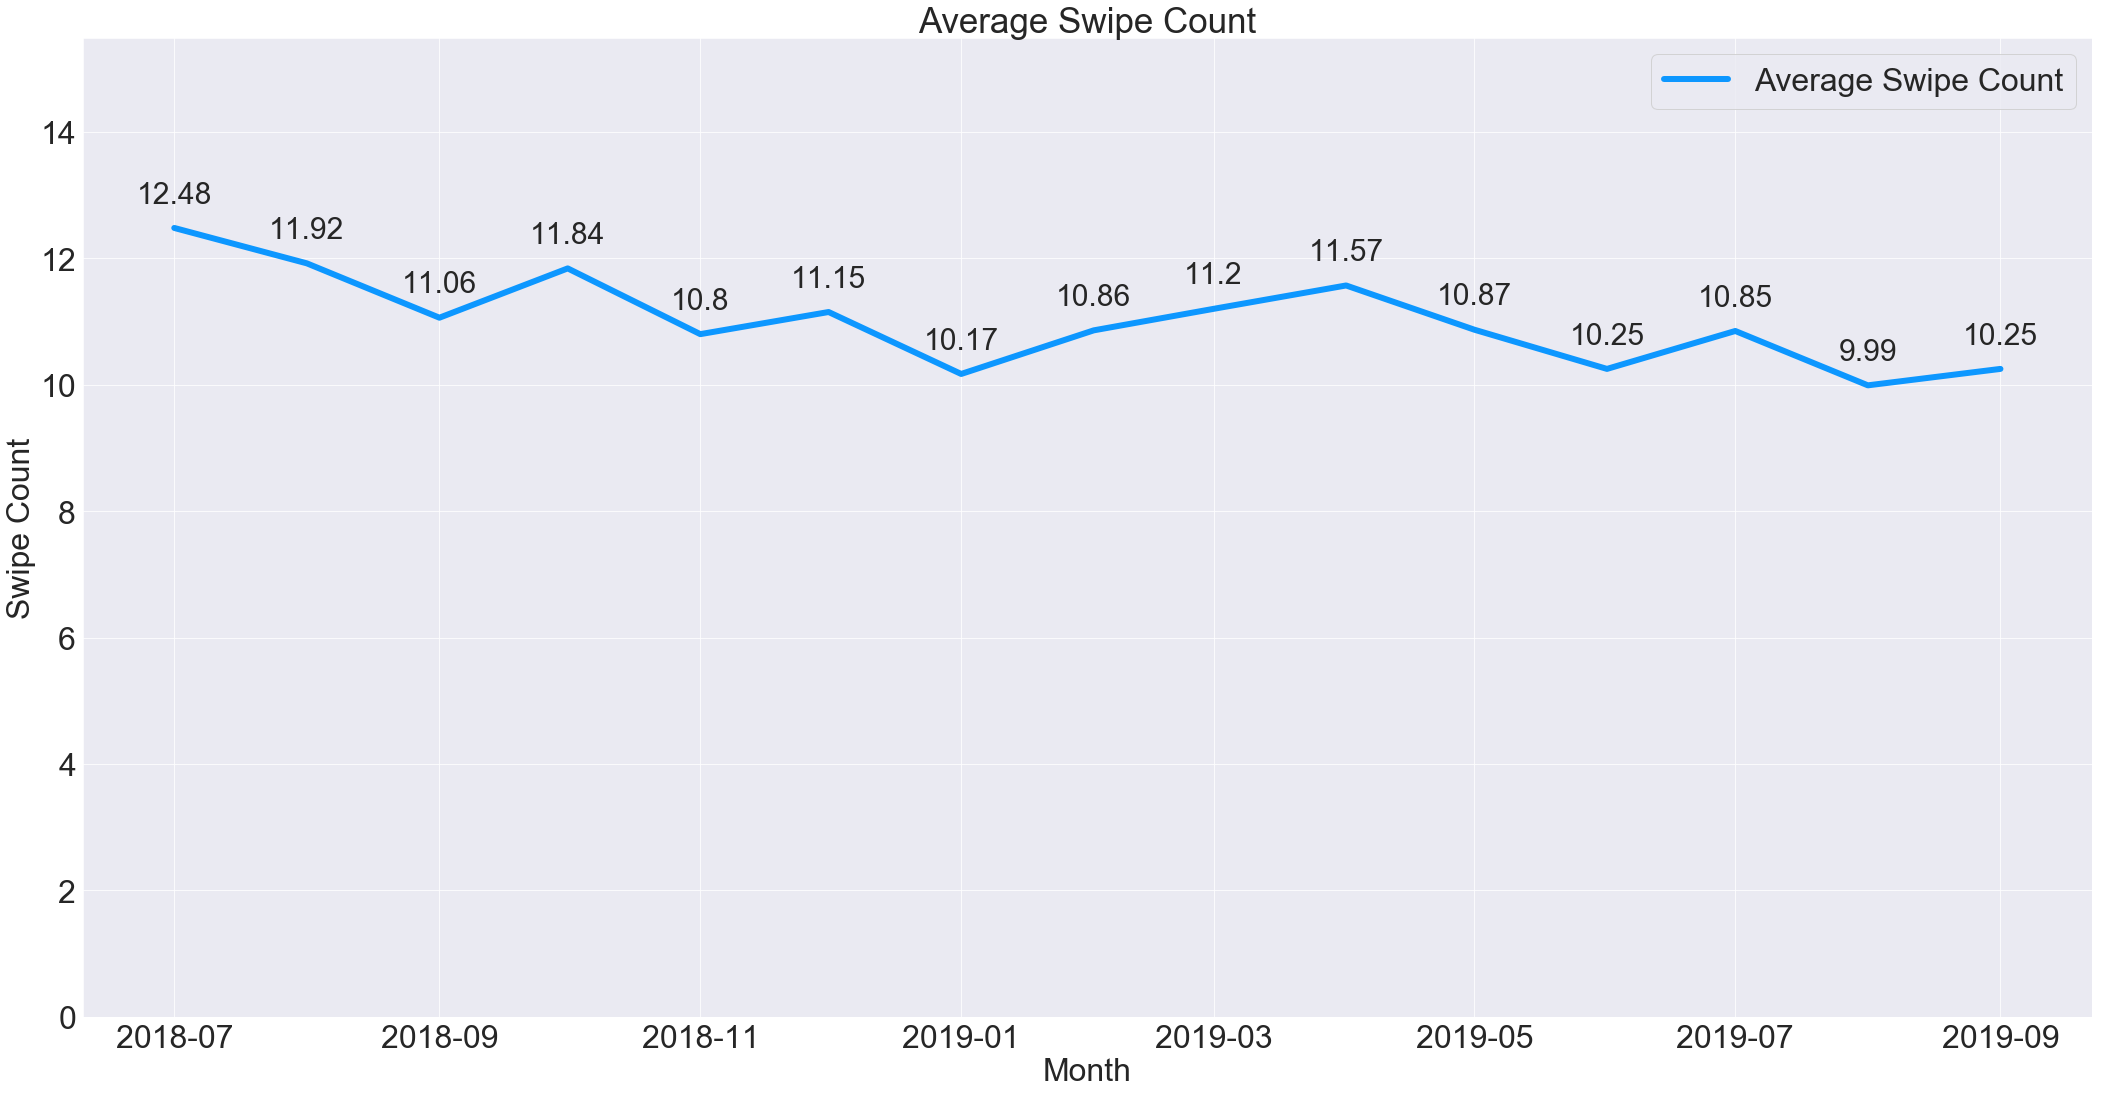

In [34]:
fig, ax = plt.subplots(figsize=(36,18))
ax.plot(swipes_after_2012.month, swipes_after_2012.avg_swipe_ct, linewidth=6)
# ax.plot(median_swipes.month, median_swipes.median_swipe_ct, linewidth=6)
plt.xlabel('Month', fontsize = 32)
plt.ylabel('Swipe Count', fontsize = 32)
plt.title('Average Swipe Count', fontsize = 35)
plt.legend(['Average Swipe Count'], fontsize=32)
plt.xticks(fontsize = 32)
plt.yticks(fontsize = 32)
plt.grid(True)
plt.ylim(0, swipes_after_2012.avg_swipe_ct.max()+3)


for m in swipes_after_2012.month:
    plt.text(m, 
             swipes_after_2012[swipes_after_2012.month == m].avg_swipe_ct+0.4, 
             str(float(swipes_after_2012[swipes_after_2012.month == m].avg_swipe_ct)),
            fontsize=30,
            ha='center')

plt.savefig('../print_screen/{}_average_swipe_count.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.


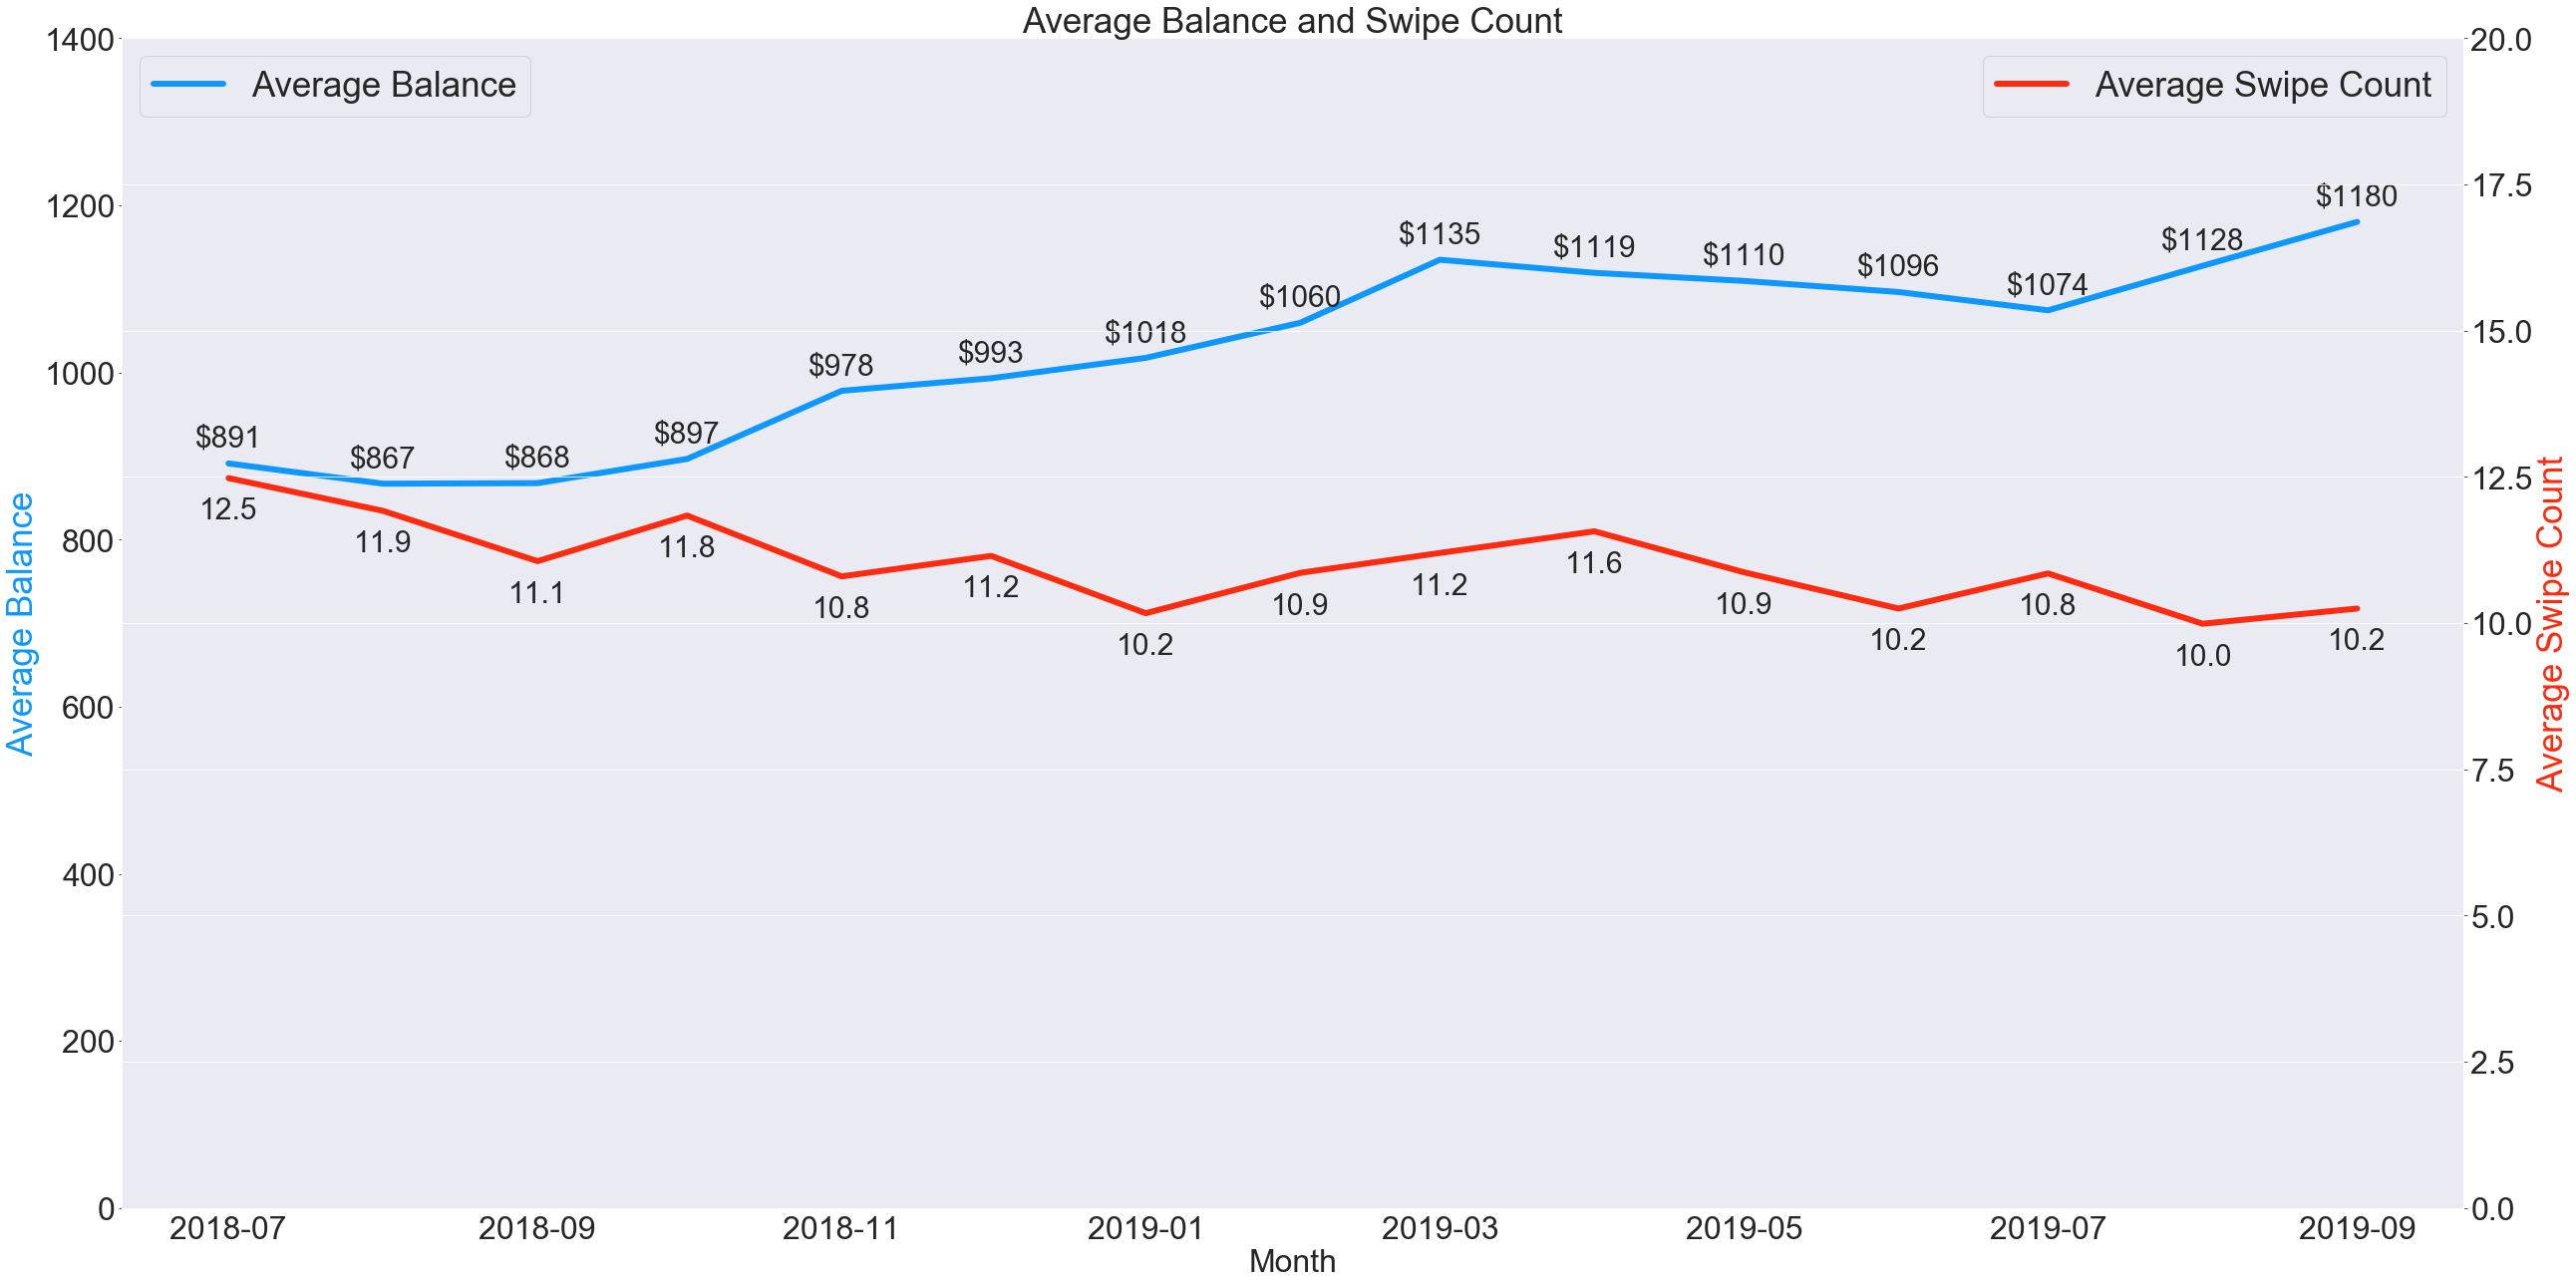

In [35]:
t = np.arange(adb.month.count())

data1 = adb.average_balance
data2 = swipes_after_2012.avg_swipe_ct

fig, ax1 = plt.subplots(figsize=(36,18))
ax1.tick_params(labelsize = 32)
color = '#0D97FF'
ax1.set_xlabel('Month',  fontsize=32)
ax1.set_ylabel('Average Balance', color=color,  fontsize=35)
ax1.plot(adb.month, data1,linewidth=6, color=color)
ax1.set_ylim(0,1400)
ax1.legend(['Average Balance'], loc='upper left',  fontsize=35)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#FD2B10'
ax2.set_ylabel('Average Swipe Count', color=color,  fontsize=35)  # we already handled the x-label with ax1
ax2.plot(adb.month, data2,linewidth=6, color=color)
ax2.set_ylim(0,20)
ax2.legend(['Average Swipe Count'], fontsize=35)
ax2.tick_params(labelsize = 32)

for i in adb.month:   
    current_value = adb[adb.month == i].average_balance
    current_value_round = round(current_value)
    current_value_str = "%d" % current_value_round
    current_value_str = "$" + current_value_str
    ax1.text(i, (current_value)+20, current_value_str, ha='center', fontsize=30) 
    
    current_value = swipes_after_2012[swipes_after_2012.month == i].avg_swipe_ct
    current_value_round = round(current_value,1)
    current_value_str = "%f" % current_value_round
    current_value_str = current_value_str[:4]
    ax2.text(i, (current_value)-0.7, current_value_str, ha='center', fontsize=30) 

plt.grid(True)    
plt.title('Average Balance and Swipe Count', fontsize=35)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('../print_screen/{}_average_balance_and_swipe_count.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

## Profitability Status

### Overall Profitability Status

In [36]:
profitability_status = read_query('profitability_status.sql')

In [37]:
# if run_from_csv:
#     positive_balance = pd.read_csv("../output/{}_Rev_Funnel_Positive_Balance_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
#     positive_balance['month'] = [dt.to_pydatetime().date() for dt in positive_balance.month]
# else:
#     positive_balance = redshift(

if run_from_csv:
    profitability_status = pd.read_csv("../output/{}_Profitability_funnel_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    profitability_status['month'] = [dt.to_pydatetime().date() for dt in profitability_status.month]
else:
    profitability_status = redshift(profitability_status)



In [38]:
# Save dataframe as CSV:
if as_csv:
    profitability_status.to_csv("../output/{}_Profitability_Status_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Profitability Status results to CSV.')

Saved Profitability Status results to CSV.


In [39]:
profitability_status = profitability_status[(profitability_status.month >= date(2018,7,1))]

In [40]:
profitable_df = profitability_status[profitability_status.revenue_funnel == 'profitable'].reset_index(drop = True)
unprofitable_login_df = profitability_status[profitability_status.revenue_funnel == 'unprofitable - login'].reset_index(drop = True)
unprofitable_no_login_df = profitability_status[profitability_status.revenue_funnel == 'unprofitable - no login'].reset_index(drop = True)

x = list(profitable_df['month'])
y = np.vstack((list(profitable_df['percent_in_funnel']), 
                    list(unprofitable_login_df['percent_in_funnel']), 
                    list(unprofitable_no_login_df['percent_in_funnel']))
               )



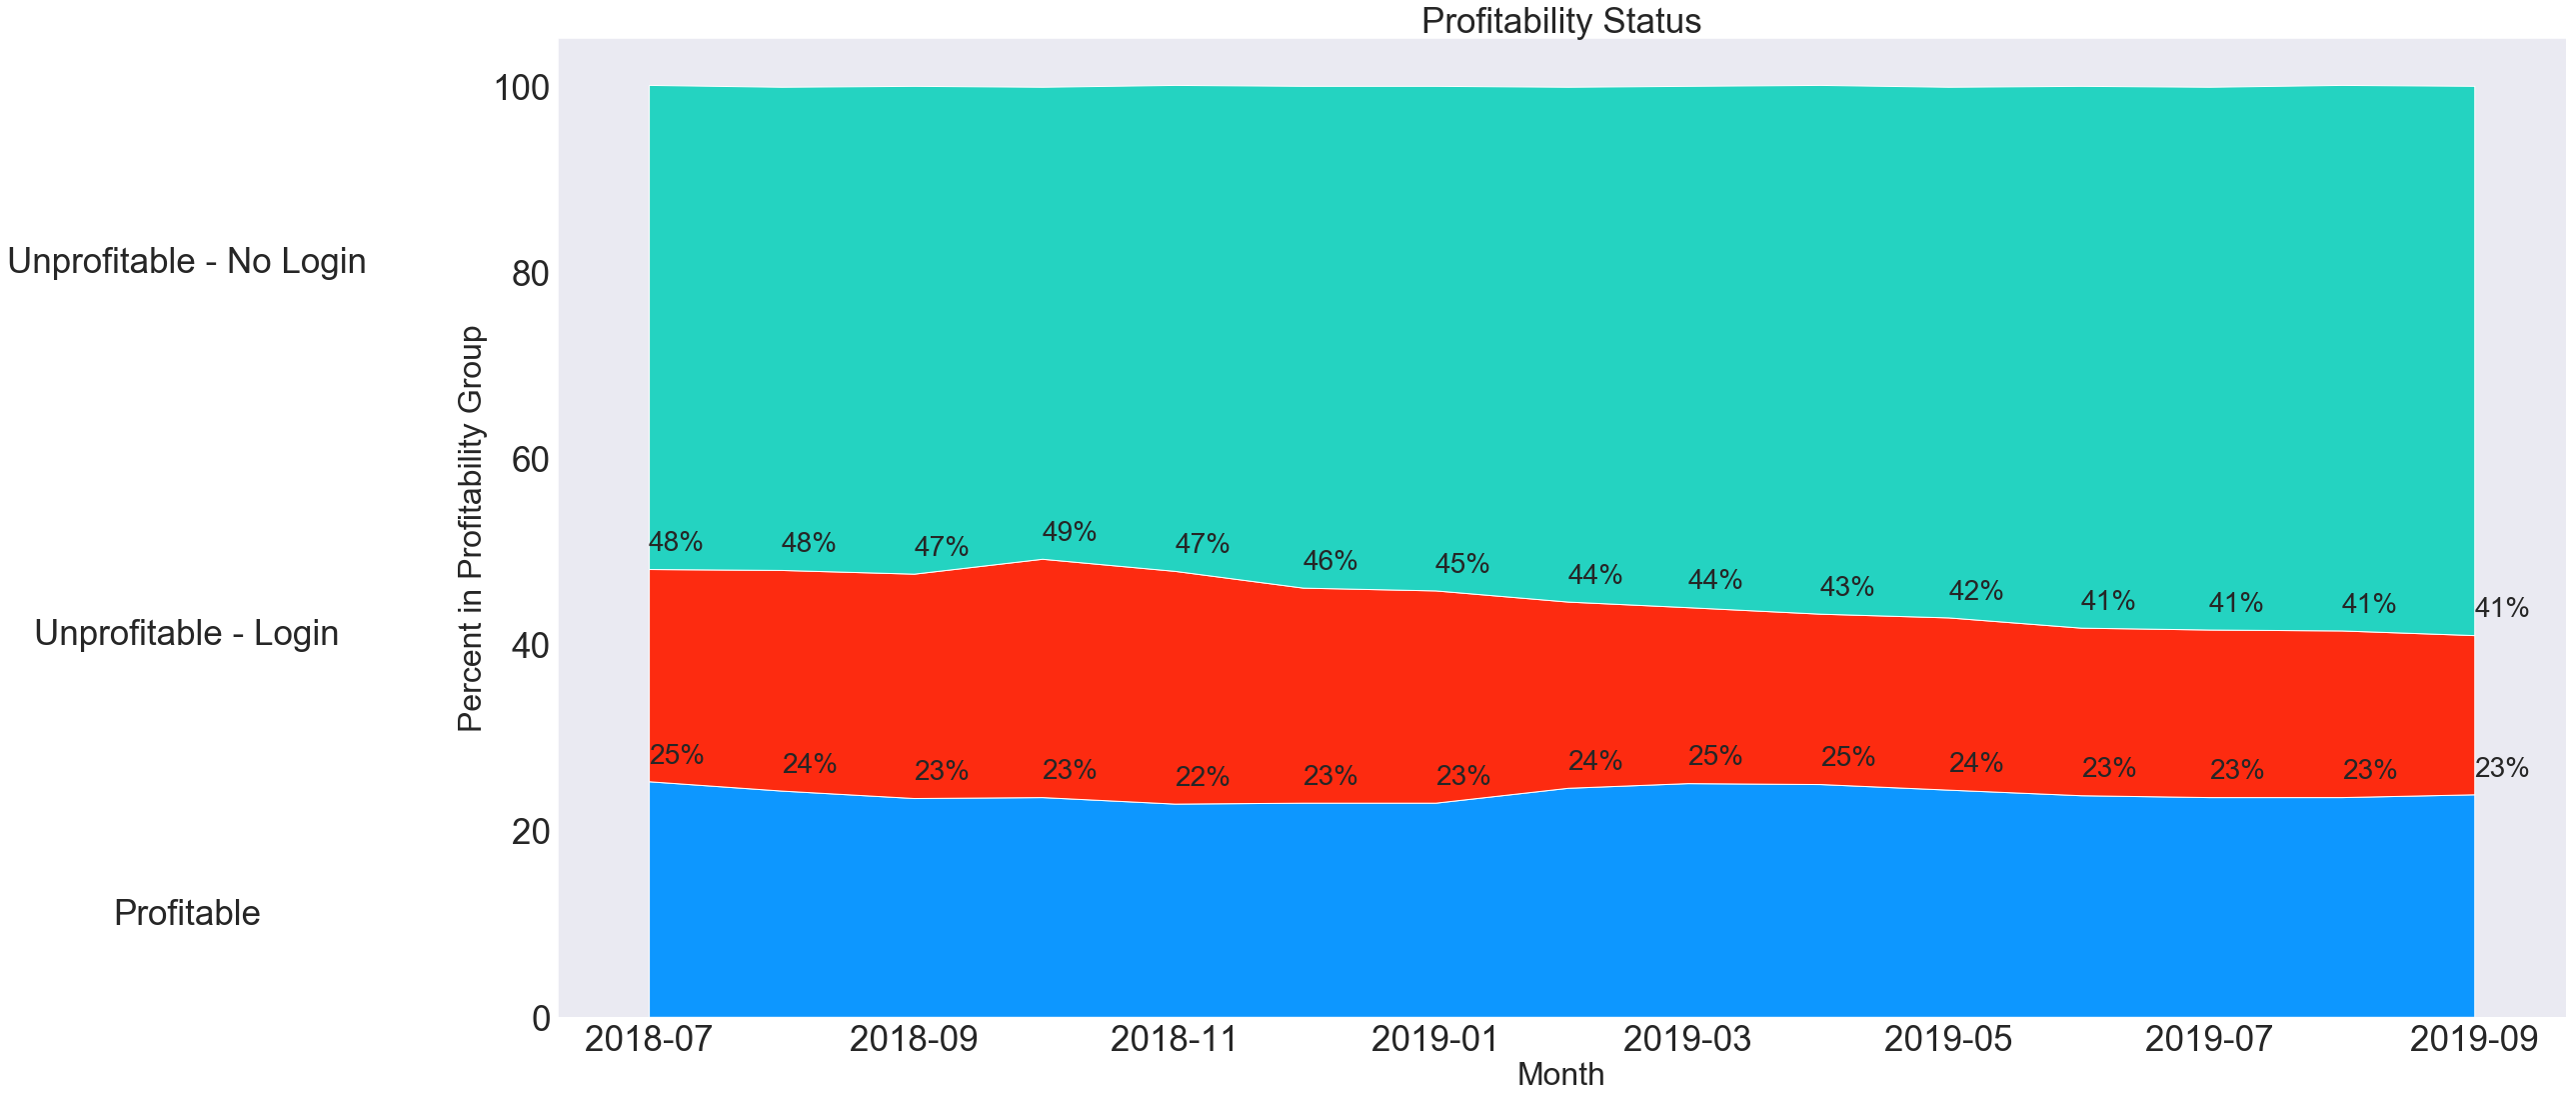

In [41]:
fix, ax = plt.subplots(figsize=(36,18))
ax.stackplot(x,y)

y_labels = [y[0], (y[0]+y[1])]

for l in y_labels: 
    i = 0
    for month in l: 
        ax.text(x[i], month + 2, str(int(month))+'%', fontsize=28, ha='left')
        i+=1

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel('Month', fontsize = 32)
plt.ylabel('Percent in Profitability Group', fontsize = 32)
plt.title('Profitability Status', fontsize = 35)
plt.text(date(2018, 3, 15), 80, 'Unprofitable - No Login', ha='center', fontsize=35)
plt.text(date(2018, 3, 15), 40, 'Unprofitable - Login', ha='center', fontsize=35)
plt.text(date(2018, 3, 15), 10, 'Profitable', ha='center', fontsize=35)

plt.savefig('../print_screen/{}_profitability_status.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))


plt.show()

### Profitability Status Breakdown

#### Balances and Swipe Count

In [42]:
adb_and_swipes = read_query('profitability_status.sql')

In [43]:
# Curated Layer

if run_from_csv:
    adb_and_swipes = pd.read_csv("../output/{}_Funnel_Breakdown_ADB_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    adb_and_swipes['month'] = [dt.to_pydatetime().date() for dt in adb_and_swipes.month]
else:
    adb_and_swipes = redshift(adb_and_swipes)
    
    

In [44]:
# Save dataframe as CSV:
if as_csv:
    adb_and_swipes.to_csv("../output/{}_Funnel_Breakdown_ADB_And_Swipes_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Funnel Breakdown ADB results to CSV.')

Saved Funnel Breakdown ADB results to CSV.


In [45]:
adb_and_swipes = adb_and_swipes[(adb_and_swipes.month >= date(2018,7,1)) & (adb_and_swipes.month < date(2019,10,1))]

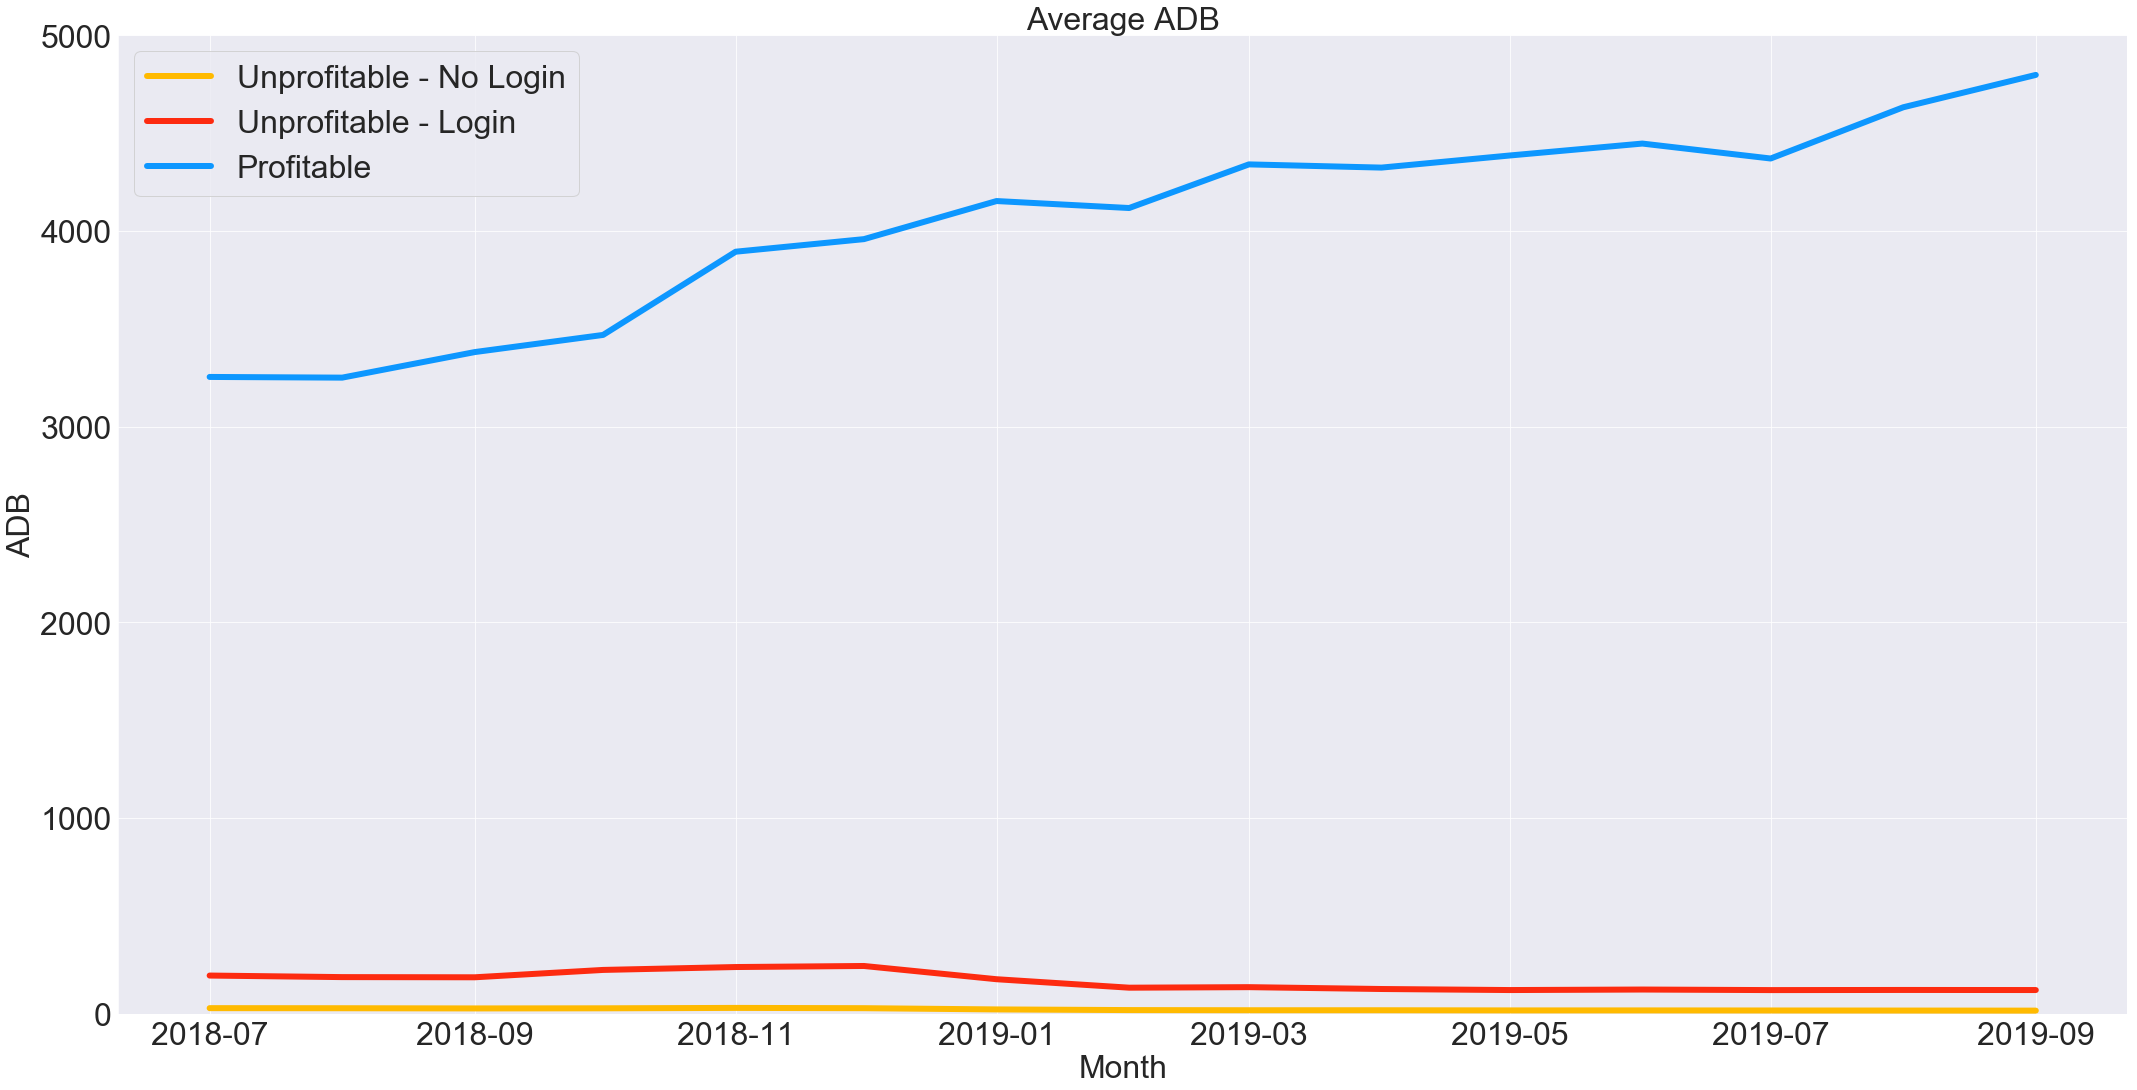

In [46]:
new_brand_palette = ['#FFBA00',  '#FD2B10', '#0D97FF','#24D3C1',   '#706AFE', '#FF9999', '#91D174',  '#005DA4', '#98D3AE']
new_goals = sns.color_palette(palette=new_brand_palette)
sns.set_palette(new_goals)

fig, ax = plt.subplots(figsize=(36,18))
ax.plot(adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - no login'].month, adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - no login'].average_balance, linewidth=6)
ax.plot(adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - login'].month, adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - login'].average_balance, linewidth=6)
ax.plot(adb_and_swipes[adb_and_swipes.revenue_funnel == 'profitable'].month, adb_and_swipes[adb_and_swipes.revenue_funnel == 'profitable'].average_balance, linewidth=6)
# ax.plot(adb[adb.rev_category == 'target_rev'].month, adb[adb.rev_category == 'target_rev'].adb, linewidth=6)
plt.grid(True)
plt.xlabel('Month', fontsize=32)
plt.ylabel('ADB', fontsize=32)
plt.title('Average ADB', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylim(0,5000)
plt.legend(['Unprofitable - No Login', 'Unprofitable - Login','Profitable'], fontsize=32)


# for m in adb_and_swipes.month:
#     plt.text(m, 
#              adb_and_swipes[adb_and_swipes.month == m].average_balance+0.4, 
#              '$'+str(int(adb_and_swipes[adb_and_swipes.month == m].average_balance)),
#             fontsize=30,
#             ha='center')


#plt.savefig('../print_screen/{}_profitability_status_adb.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))

plt.show()

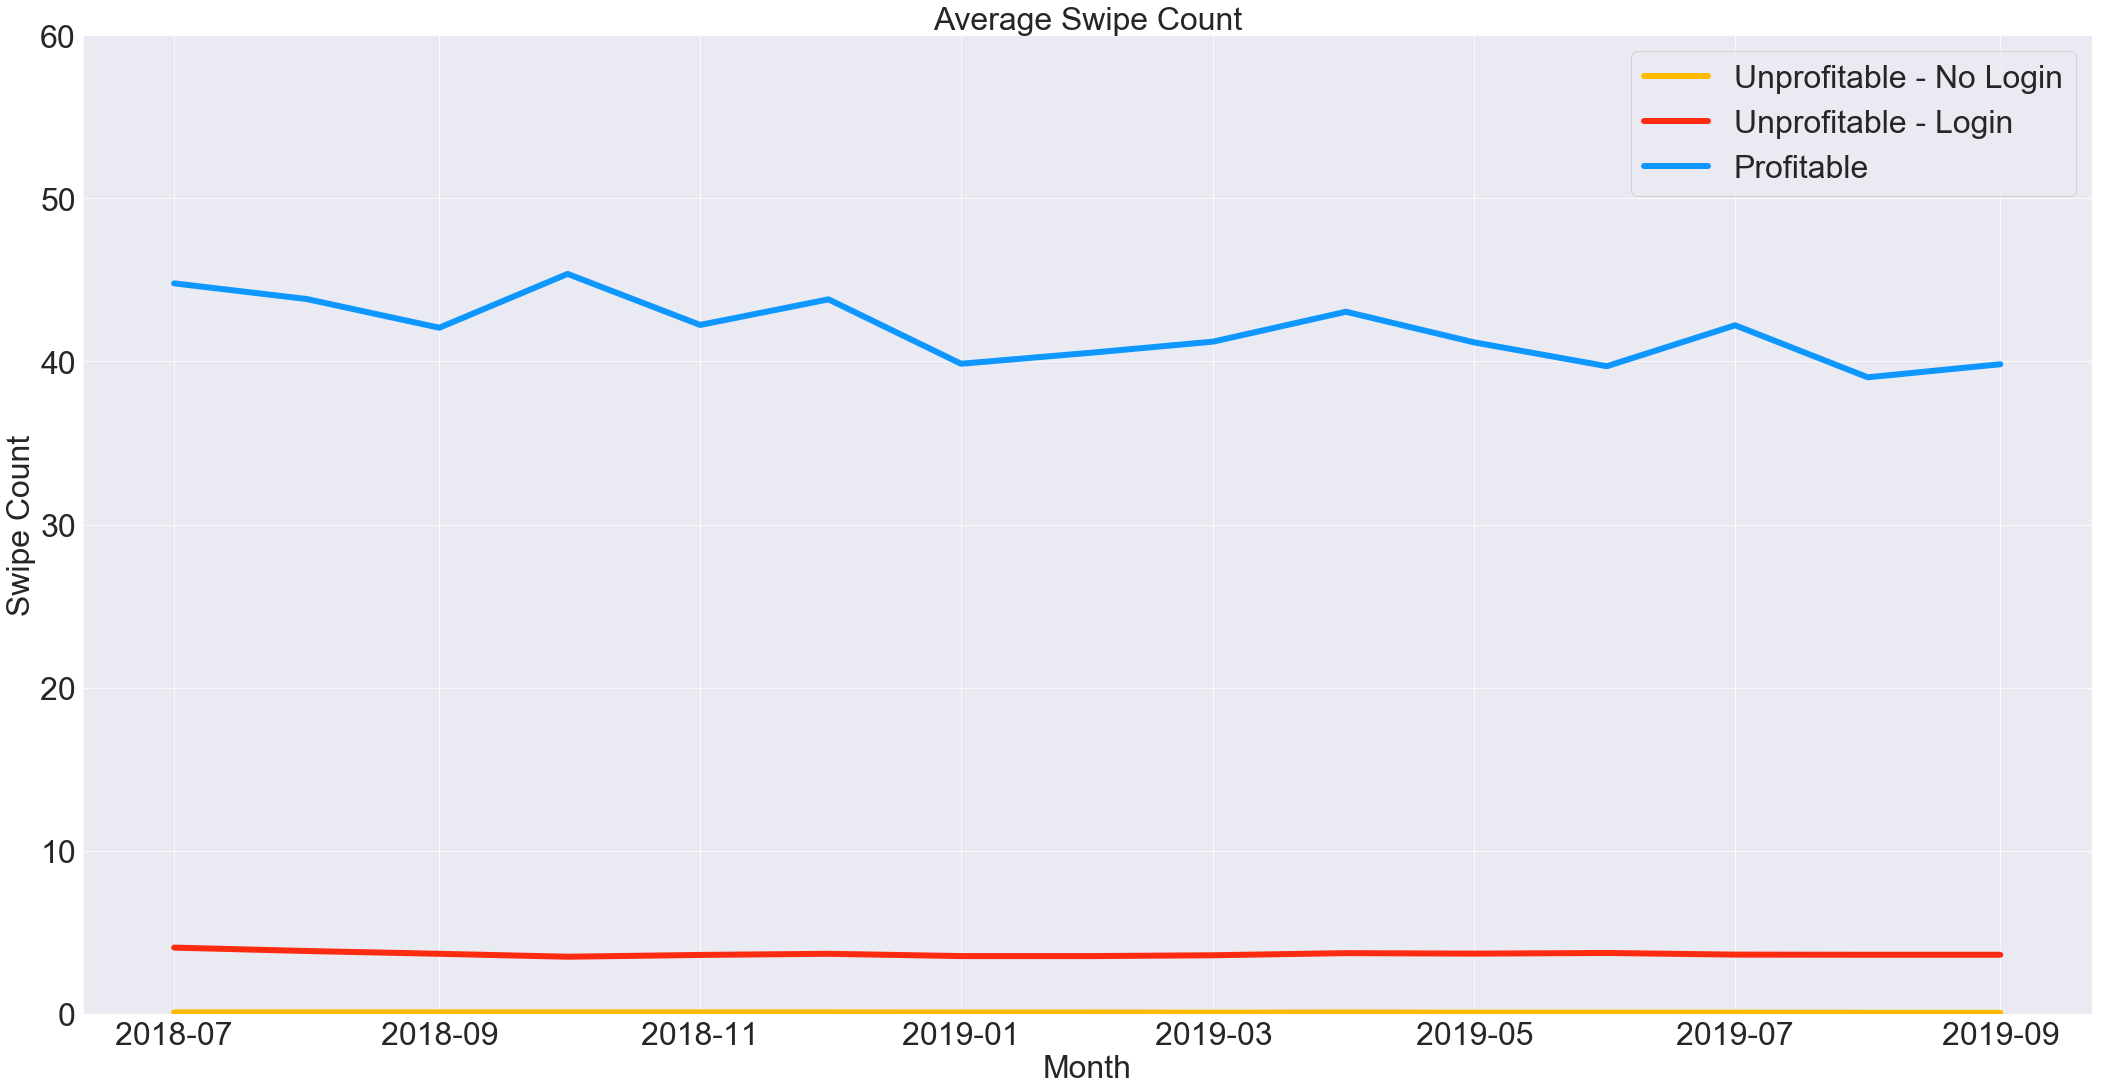

In [47]:
new_brand_palette = ['#FFBA00',  '#FD2B10', '#0D97FF','#24D3C1',   '#706AFE', '#FF9999', '#91D174',  '#005DA4', '#98D3AE']
new_goals = sns.color_palette(palette=new_brand_palette)
sns.set_palette(new_goals)

fig, ax = plt.subplots(figsize=(36,18))
ax.plot(adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - no login'].month, adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - no login'].swipe_count, linewidth=6)
ax.plot(adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - login'].month, adb_and_swipes[adb_and_swipes.revenue_funnel == 'unprofitable - login'].swipe_count, linewidth=6)
ax.plot(adb_and_swipes[adb_and_swipes.revenue_funnel == 'profitable'].month, adb_and_swipes[adb_and_swipes.revenue_funnel == 'profitable'].swipe_count, linewidth=6)
# ax.plot(adb[adb.rev_category == 'target_rev'].month, adb[adb.rev_category == 'target_rev'].adb, linewidth=6)
plt.grid(True)
plt.xlabel('Month', fontsize=32)
plt.ylabel('Swipe Count', fontsize=32)
plt.title('Average Swipe Count', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylim(0,60)
plt.legend(['Unprofitable - No Login', 'Unprofitable - Login','Profitable'], fontsize=32)
plt.savefig('../print_screen/{}_profitability_status_swipe_count.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))

plt.show()

## 90-Day Target Revenue Rate

### 2017 Cohorts (Line Graph)

In [48]:
single_month_tr = read_query('New_Customer_Target_Revenue_Rate_Monthly.sql')

In [49]:
if run_from_csv:
    single_month_tr = pd.read_csv("../output/{}_New_Customer_Target_Revenue_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    single_month_tr['cohort'] = [dt.to_pydatetime().date() for dt in single_month_tr.cohort]
else:
    single_month_tr = redshift(single_month_tr)


In [50]:
# Save dataframe as CSV:
if as_csv:
    single_month_tr.to_csv("../output/{}_New_Customer_Target_Revenue_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved New Customer Target Revenue results to CSV.')

Saved New Customer Target Revenue results to CSV.


In [51]:
single_month_tr = single_month_tr[single_month_tr.cohort >= date(2018,7,1)]
single_month_tr = single_month_tr[single_month_tr.months_enrolled >= 0]

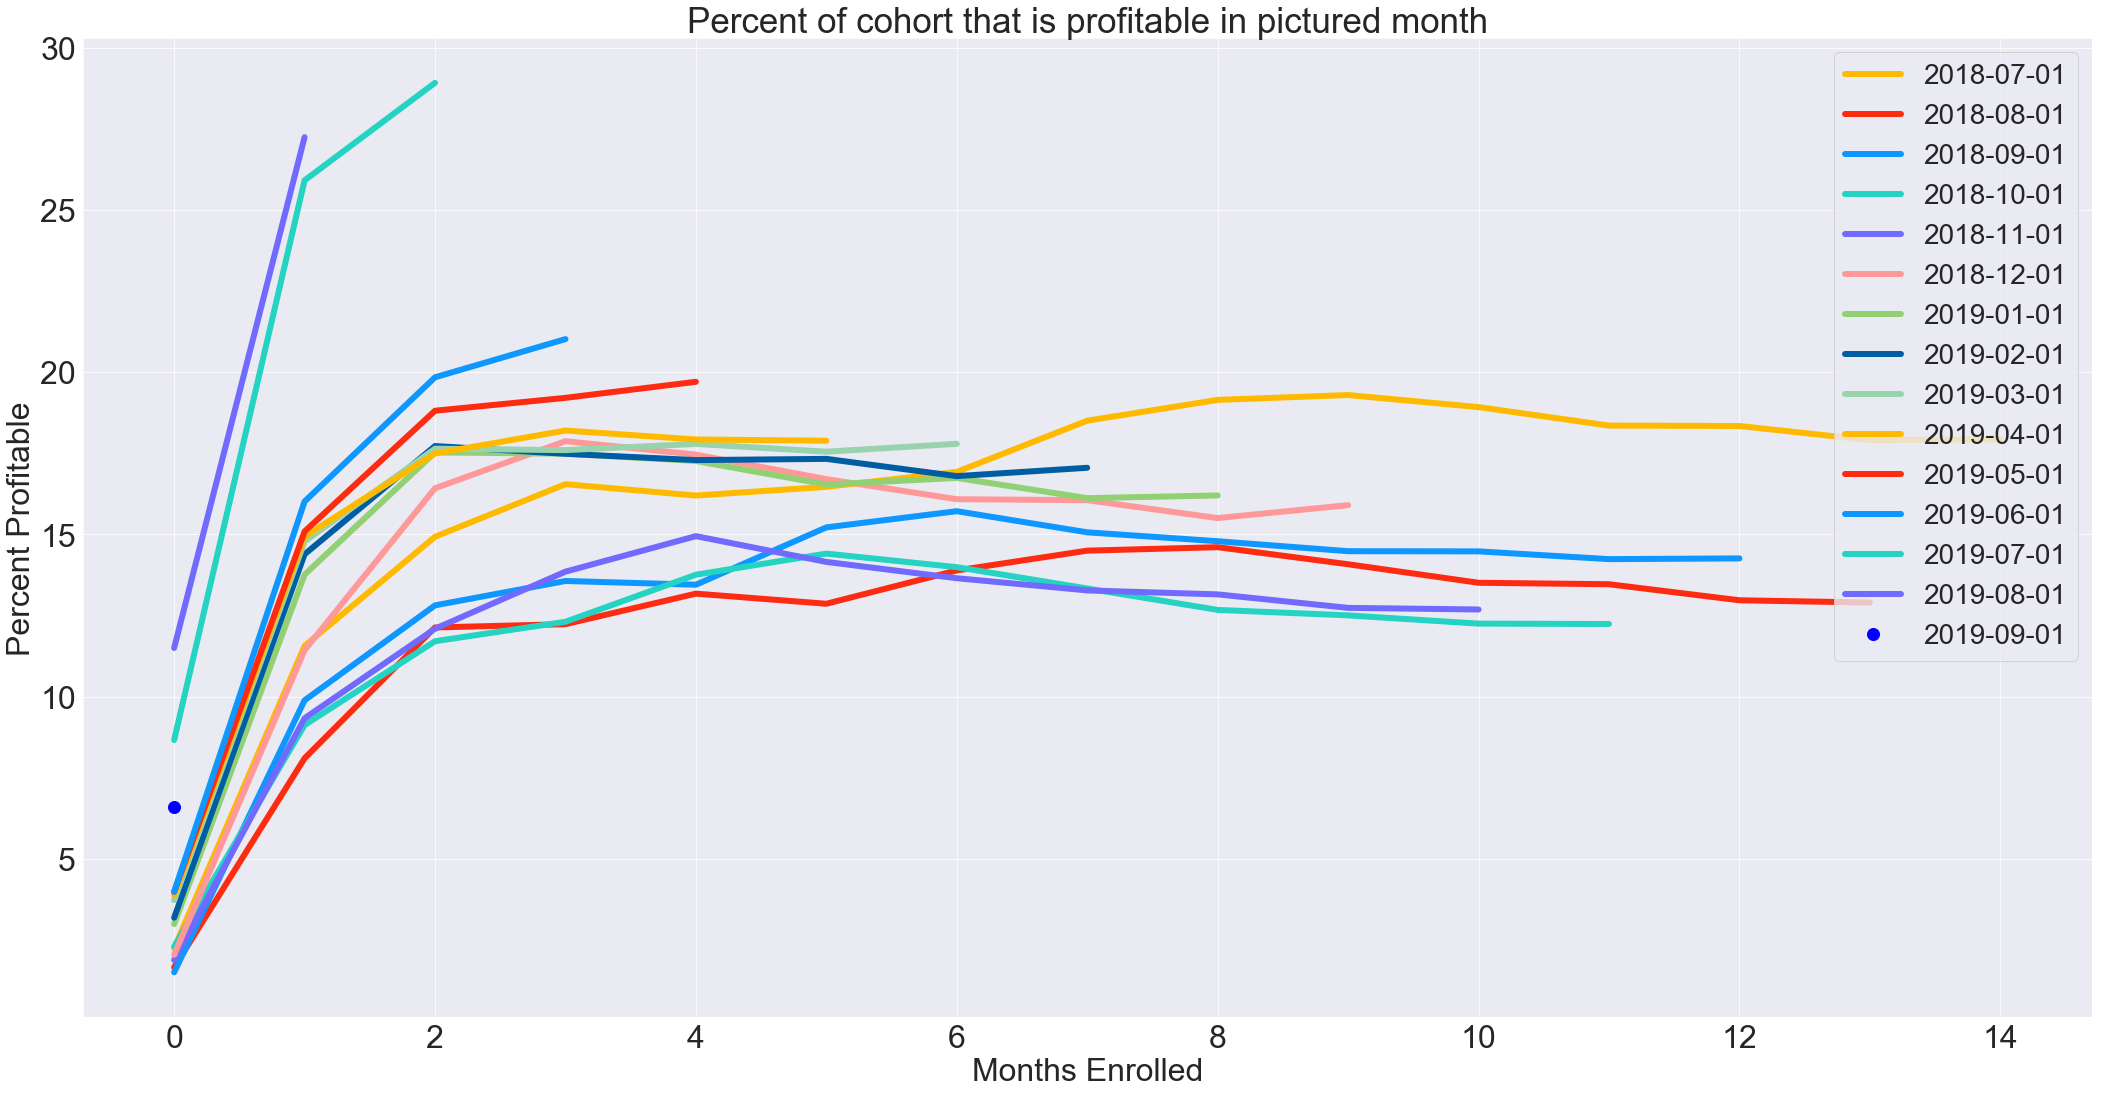

In [52]:
last_month = date(date.today().year, date.today().month, 1) + relativedelta.relativedelta(months=-1)

fig, ax = plt.subplots(figsize=(36,18))

c = single_month_tr.cohort.unique()
for x in c:
    if x == last_month:
        ax.plot(single_month_tr[single_month_tr.cohort == x].months_enrolled, single_month_tr[single_month_tr.cohort == x].target_rev_rate, 'bo', ms=12)
    else:
        ax.plot(single_month_tr[single_month_tr.cohort == x].months_enrolled, single_month_tr[single_month_tr.cohort == x].target_rev_rate, linewidth=6)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylabel('Percent Profitable', fontsize=32)
plt.xlabel('Months Enrolled', fontsize=32)
plt.title('Percent of cohort that is profitable in pictured month', fontsize=35)
plt.legend(single_month_tr.cohort.unique(), fontsize=28)




plt.grid(True)
plt.savefig('../print_screen/{}_profitable_percent_of_cohort.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))

# plt.ylim(0,30)


### All Years

In [53]:
yearly_tr_rate = read_query('New_Customer_Target_Revenue_Rate_Yearly.sql')

In [54]:
if run_from_csv:
    yearly_tr_rate = pd.read_csv("../output/{}_New_Customer_Yearly_Profitable_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    yearly_tr_rate['cohort'] = [dt.to_pydatetime().date() for dt in yearly_tr_rate.cohort]
else:
    yearly_tr_rate = redshift(yearly_tr_rate)


In [55]:
# Save dataframe as CSV:
if as_csv:
    yearly_tr_rate.to_csv("../output/{}_New_Customer_Yearly_Profitable_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved New Customer Profitable results to CSV.')

Saved New Customer Profitable results to CSV.


### CONVERTED TO MARKDOWN TO AVOID ERROR
plt.figure(figsize=(36,18))
x = [0,1,2,3,4,5,6]  #,6]
y = yearly_tr_rate.target_rev_rate
title = 'Percent of profitable customers in third month'
ylabel = 'Percent of customers'
ylow = 0
ylim = 100
colors= ['#0D97FF', '#FD2B10', '#24D3C1', '#FFBA00', '#706AFE', '#FF9999', '#FF673D',  '#91D174',  '#005DA4', '#98D3AE']
labels = ['2012','2013','2014','2015','2016','2017','2018']  #, '2018 (So Far)']
plt.bar(x,y, color = colors)
plt.ylabel(ylabel, fontsize=30)
plt.title(title, fontsize=30)
plt.xticks(x,labels, fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(ylow,ylim)
plt.grid(True)
for n in x:
    plt.text(x[n],y[n]+1,int(y[n]), ha='center', fontsize=30)

plt.savefig('../print_screen/{}_profitable_third_month.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

---

## Savings Rate

### Skipping this section, not sure if its still relevant (and it uses old mtrs)

In [53]:
savings = redshift("""
WITH monthly AS(
SELECT DISTINCT user_id,
    month::date AS month_value, 
    sum(credit_volume) AS credits,
    sum(debit_volume) AS debits
FROM mtr_daily_customer_activity
JOIN mtr_user_demographics USING (user_id)
JOIN mtr_user_first_activity USING (user_id)
GROUP BY 1,2
ORDER BY 1,2
),

with_prev AS(
SELECT DISTINCT m.user_id, 
    month_value,
    DATEADD(month, -1, month_value) AS prev_month,
    credits,
    debits,
    sum(credit_volume) AS credits_prev,
    sum(debit_volume) AS debits_prev
FROM monthly m
JOIN mtr_daily_customer_activity a ON m.user_id = a.user_id 
    AND DATEADD(month, -1, m.month_value)::DATE = a.month::DATE
GROUP BY 1,2,3,4,5
)

SELECT DISTINCT 
    user_id, 
    month_value AS month,
    credits+credits_prev AS credits,
    debits+debits_prev AS debits
FROM with_prev
ORDER BY 2
"""
)

In [54]:
# # Save dataframe as CSV:
# if as_csv:
#     savings.to_csv("../../output/{}_Savings_Rate_Archive.csv".format(date.today().strftime('%y-%m-%d')))
#     print('Saved Savings Rate results to CSV.')

In [55]:
savings['rate']  =  savings['credits'].map(lambda x: np.nan if x == 0 else x)
savings['rate'] = (savings.rate - savings.debits)/savings.rate*100

monthly_rate = savings.groupby('month').median().reset_index()

In [56]:
# Save dataframe as CSV:
if as_csv:
    monthly_rate.to_csv("../output/{}_Savings_Rate_Archive.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Savings Rate results to CSV.')

Saved Savings Rate results to CSV.


In [57]:
if run_from_csv:
    monthly_rate = pd.read_csv("../output/{}_Savings_Rate_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    monthly_rate['month'] = [dt.to_pydatetime().date() for dt in monthly_rate.month]
else:
    pass

In [58]:
new_brand_palette = ['#0D97FF', '#FD2B10', '#24D3C1', '#FFBA00', '#706AFE', '#FF9999', '#FF673D',  '#91D174', '#005DA4', '#98D3AE', '#F0D9A8', '#89EA29']
new_goals = sns.color_palette(palette=new_brand_palette)
sns.set_palette(new_goals)

In [59]:
monthly_rate = monthly_rate[(monthly_rate.month >= date(2018,4,1)) & (monthly_rate.month < date(2019,7,1))]

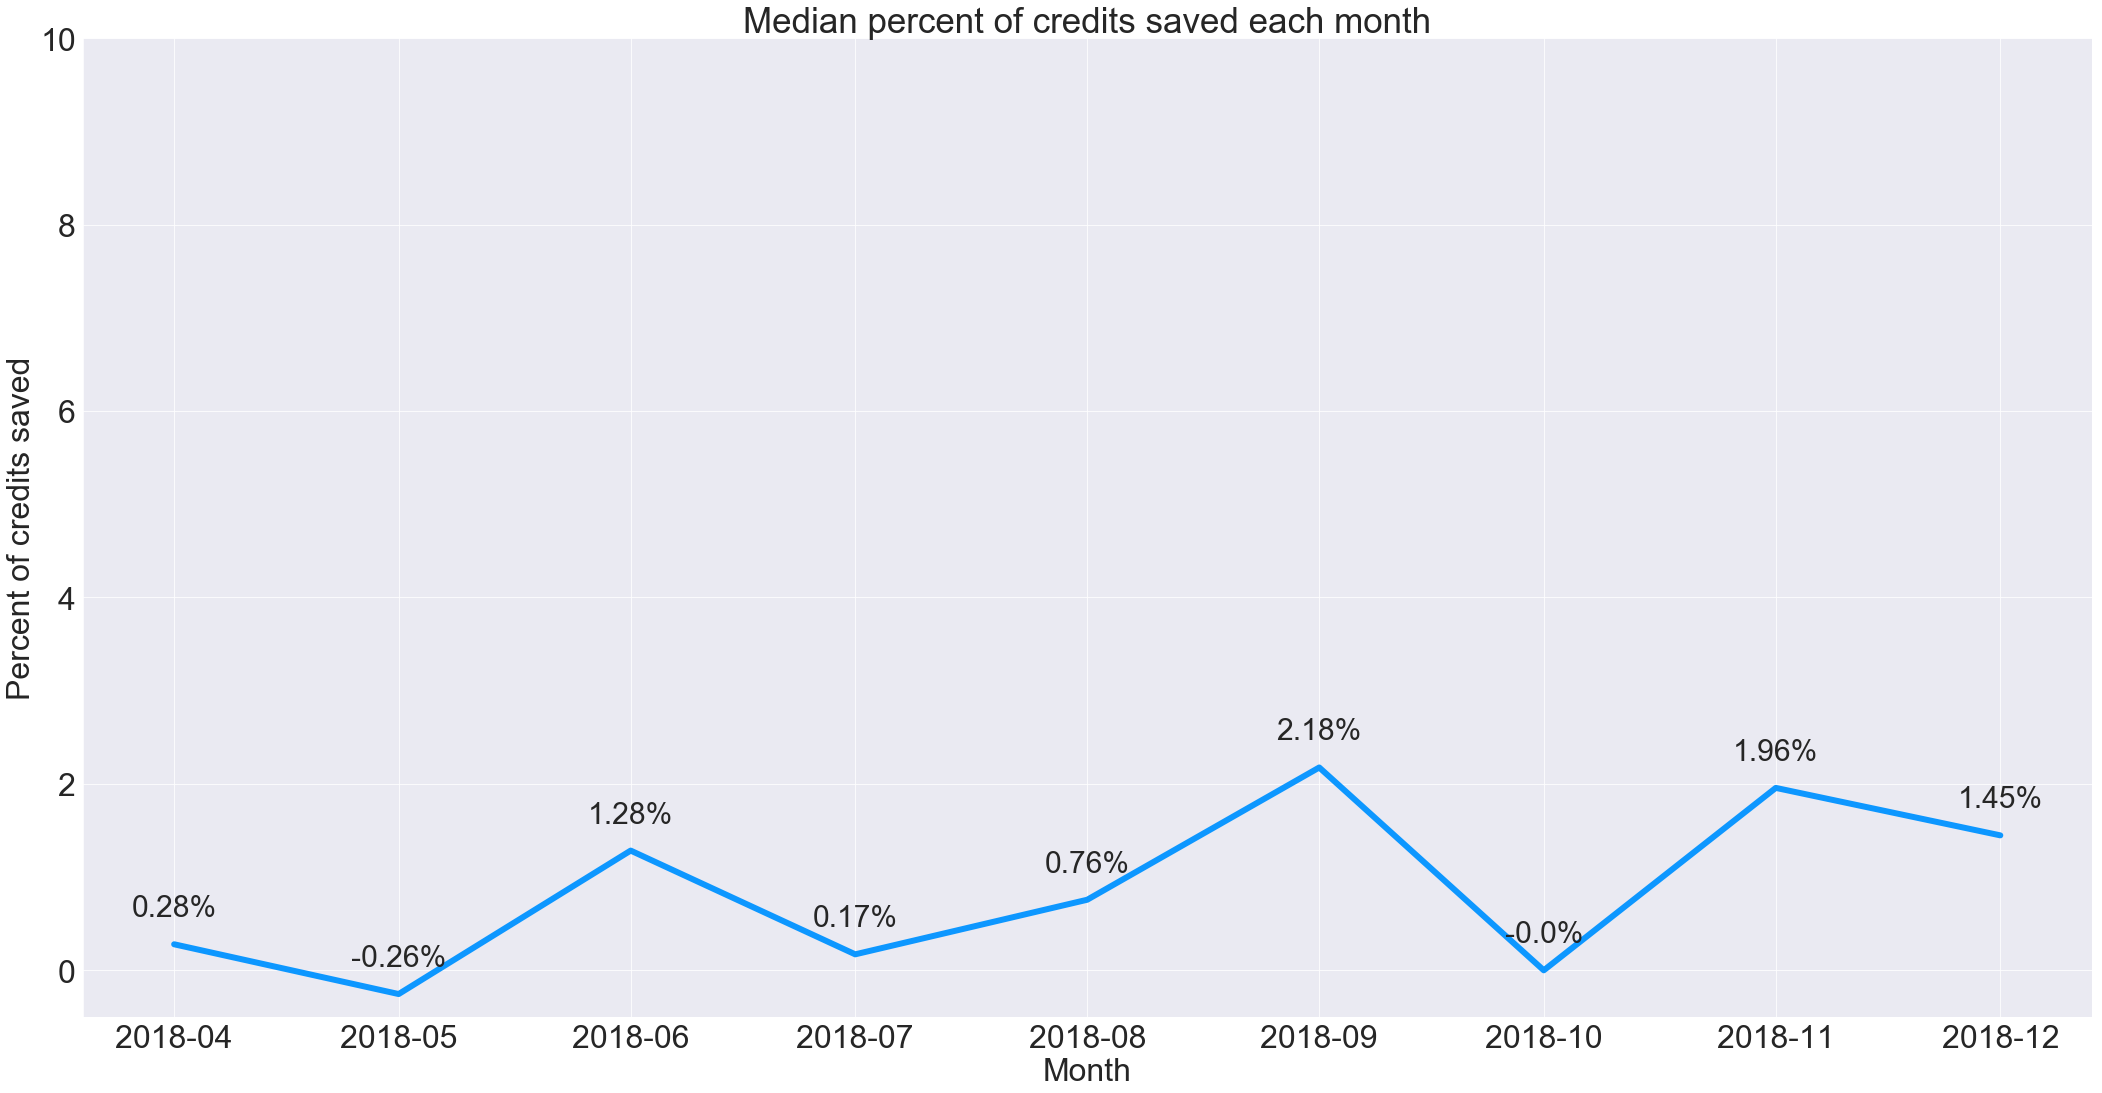

In [60]:

fig, ax = plt.subplots(figsize=(36,18))
d = monthly_rate[(monthly_rate.month >= date(2017,4,1)) & (monthly_rate.month < date(date.today().year, date.today().month, 1))].copy()
ax.plot(d['month'], d['rate'], linewidth=6)
plt.xlabel('Month', fontsize=32)
plt.ylabel('Percent of credits saved', fontsize=32)
plt.ylim(-.5,10)
plt.title('Median percent of credits saved each month', fontsize=35)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.grid(True)


for m in monthly_rate.month:
    plt.text(m, 
             monthly_rate[monthly_rate.month == m].rate+0.3, 
             str(round(float(monthly_rate[monthly_rate.month == m].rate),2))+'%',
            fontsize=30,
            ha='center')

plt.savefig('../print_screen/{}_saving_rate.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

## Account Type

In [56]:
percent_protected_goal = read_query('percent_customers_protected_goal.sql')

In [57]:
if run_from_csv:
    percent_protected_goal = pd.read_csv("../output/{}_Percent_protected_goal_Archive.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    percent_protected_goal['month'] = [dt.to_pydatetime().date() for dt in percent_protected_goal.month]
else:
    percent_protected_goal = redshift(percent_protected_goal)

In [58]:
percent_protected_goal = percent_protected_goal[(percent_protected_goal.month >= date(2018,7,1)) & (percent_protected_goal.month < date(2019,10,1))]

In [59]:
percent_protected_goal.reset_index()

,index,month,protected_goal_accounts,total_users,percent_with_protected_goal
0,9,2018-07-01,35865,371948,9.6
1,10,2018-08-01,39066,387825,10.1
2,11,2018-09-01,47586,402750,11.8
3,12,2018-10-01,57680,419927,13.7
4,13,2018-11-01,61740,438714,14.1
5,14,2018-12-01,66535,450665,14.8
6,15,2019-01-01,70902,465871,15.2
7,16,2019-02-01,76909,475052,16.2
8,17,2019-03-01,81273,483751,16.8
9,18,2019-04-01,84470,491476,17.2


In [60]:
if as_csv:
    percent_protected_goal.to_csv("../output/{}_percent_protected_goal.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Percent Protected Goal results to CSV.')

Saved Percent Protected Goal results to CSV.


In [61]:
percent_protected_goal

,month,protected_goal_accounts,total_users,percent_with_protected_goal
9,2018-07-01,35865,371948,9.6
10,2018-08-01,39066,387825,10.1
11,2018-09-01,47586,402750,11.8
12,2018-10-01,57680,419927,13.7
13,2018-11-01,61740,438714,14.1
14,2018-12-01,66535,450665,14.8
15,2019-01-01,70902,465871,15.2
16,2019-02-01,76909,475052,16.2
17,2019-03-01,81273,483751,16.8
18,2019-04-01,84470,491476,17.2


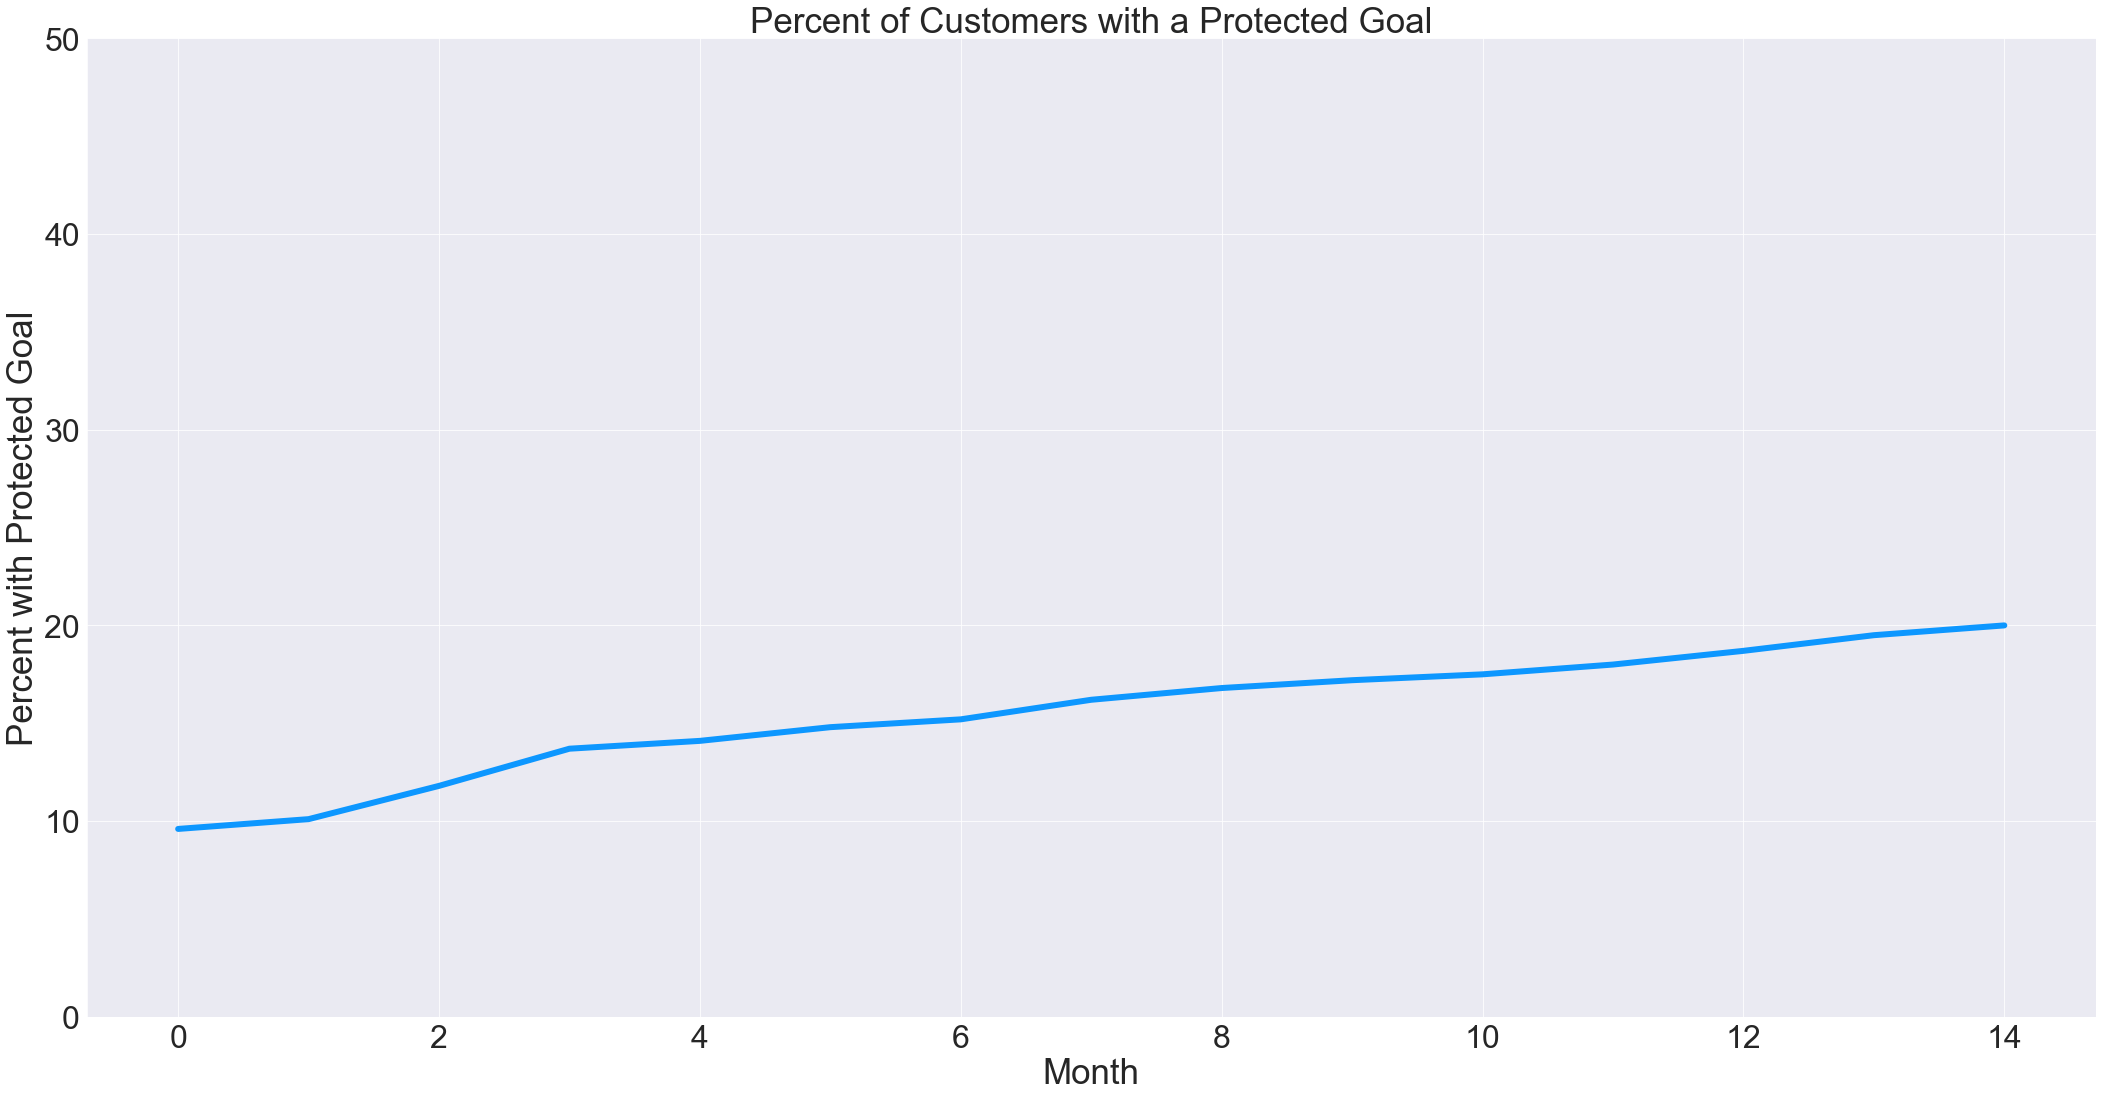

In [65]:
fig, ax = plt.subplots(figsize=(36,18))
# plt.figure(figsize=(36,18))
ax.plot(list(range(0,len(percent_protected_goal.month))),percent_protected_goal.percent_with_protected_goal,linewidth = 6)
# labels = ['March 2018','April 2018']
labels = list(percent_protected_goal.month.unique())
# ax.set_xticks(list(range(0,len(percent_protected_goal.month))))
# ax.set_xticklabels(labels, fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.ylim(0,50)
plt.title('Percent of Customers with a Protected Goal', fontsize=35)
plt.xlabel('Month', fontsize=35)
plt.ylabel('Percent with Protected Goal',fontsize=35)
plt.grid(True)

# for m in percent_protected_goal.month:
#     plt.text(m, 
#              percent_protected_goal[percent_protected_goal.month == m].percent_with_protected_goal, 
#              '$'+str(float(percent_protected_goal[percent_protected_goal.month == m].percent_with_protected_goal)),
#             fontsize=20,
#             ha='center')
    


# ax.set_xticks(percent_protected_goal.month)

plt.savefig('../print_screen/{}_percent_protected_goal.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

### ADB by Account Type

In [66]:
adb_account_type = read_query('adb_by_account_type_curated.sql')

In [67]:
if run_from_csv:
    adb_account_type = pd.read_csv("../output/{}_adb_by_account_type.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    adb_account_type['month'] = [dt.to_pydatetime().date() for dt in adb_account_type.month]
else:
    adb_account_type = redshift(adb_account_type)

In [68]:
if as_csv:
    adb_account_type.to_csv("../output/{}_ADB_by_account_type.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved ADB by Account Type results to CSV.')

Saved ADB by Account Type results to CSV.


In [69]:
adb_account_type = adb_account_type[(adb_account_type.month >= date(2018,7,1)) & (adb_account_type.month < date(2019,10,1))]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [70]:
adb_checking = adb_account_type[adb_account_type.account_type == 'checking'].reset_index()
adb_shared = adb_account_type[adb_account_type.account_type == 'shared'].reset_index()
adb_ef = adb_account_type[adb_account_type.account_type == 'protected'].reset_index()

In [71]:
adb_ef = adb_ef[(adb_ef.month >= date(2018,7,1))]
adb_ef = adb_ef.reset_index()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


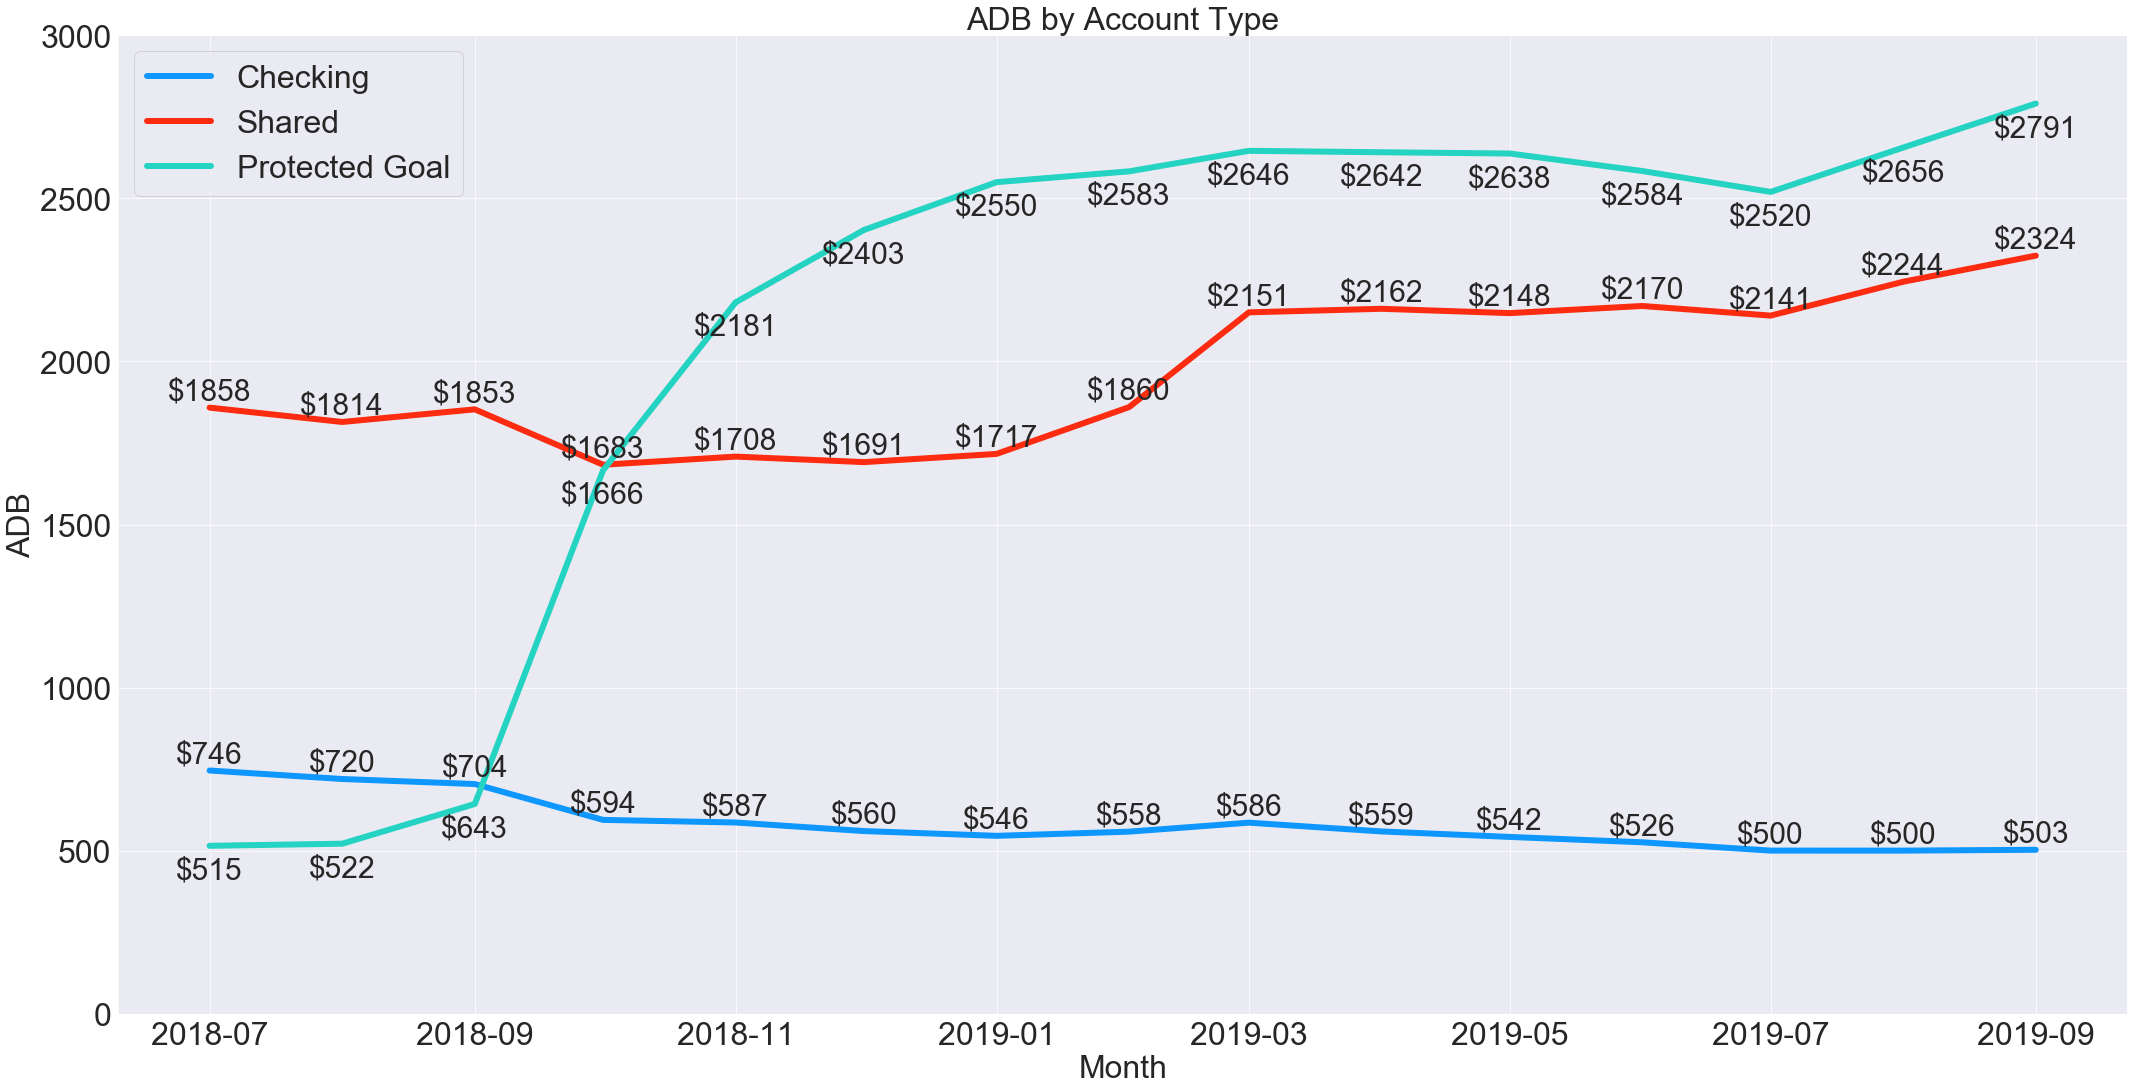

In [72]:
fig, ax = plt.subplots(figsize=(36,18))
months = adb_checking.month

p1 = ax.plot(adb_checking.month, adb_checking.avg_balance, linewidth=6)
p2 = ax.plot(adb_shared.month, adb_shared.avg_balance, linewidth=6)
p3 = ax.plot(adb_ef.month, adb_ef.avg_balance, linewidth=6)


for m in adb_checking.month:
    plt.text(m, 
             adb_checking[adb_checking.month == m].avg_balance+25, 
             '$'+str(round(float(adb_checking[adb_checking.month == m].avg_balance))),
            fontsize=30,
            ha='center')
    
for n in adb_shared.month:
    plt.text(n, 
             adb_shared[adb_shared.month == n].avg_balance+25, 
             '$'+str(round(float(adb_shared[adb_shared.month == n].avg_balance))),
            fontsize=30,
            ha='center')

for p in adb_ef.month:
    plt.text(p, 
             adb_ef[adb_ef.month == p].avg_balance-100, 
             '$'+str(round(float(adb_ef[adb_ef.month == p].avg_balance))),
            fontsize=30,
            ha='center')

plt.ylim(0,3000)
plt.xlabel('Month', fontsize = 32)
plt.xticks(fontsize = 32)
plt.ylabel('ADB', fontsize = 32)
plt.yticks(fontsize = 32)
plt.title('ADB by Account Type', fontsize = 32)
plt.legend(['Checking','Shared','Protected Goal'], fontsize=32)
plt.grid(True)

plt.savefig('../print_screen/{}_adb_account_type.png'.format(date.today().strftime('%Y-%m-%d'), bbox_inches='tight'))
plt.show()

### Total Balances by Account Type

In [73]:
total_balances_account_type = read_query('total_balance_by_account_type.sql')

In [74]:
if run_from_csv:
    total_balances_account_type = pd.read_csv("../output/{}_total_balances_by_account_type.csv".format(prefix), index_col=0, date_parser=dateparse, parse_dates=[1])
    total_balances_account_type['month'] = [dt.to_pydatetime().date() for dt in total_balances_account_type.month]
else:
    total_balances_account_type = redshift(total_balances_account_type)

In [75]:
if as_csv:
    total_balances_account_type.to_csv("../output/{}_total_balances_by_account_type.csv".format(date.today().strftime('%Y-%m-%d')))
    print('Saved Total Balances by Account Type to CSV.')

Saved Total Balances by Account Type to CSV.


In [76]:
total_balances_account_type = total_balances_account_type[(total_balances_account_type.month >= date(2018,7,1)) & (total_balances_account_type.month < date(2019,10,1))]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [77]:
total_balances_account_type['total_balance_millions'] = total_balances_account_type.total_balance/1000000 

In [78]:
total_checking = total_balances_account_type[total_balances_account_type.account_type == 'checking'].reset_index()
total_shared = total_balances_account_type[total_balances_account_type.account_type == 'shared'].reset_index()
total_protected = total_balances_account_type[total_balances_account_type.account_type == 'protected'].reset_index()
print(total_protected)

    index      month account_type  total_balance  total_balance_millions
0     121 2018-07-01    protected   1.766771e+07               17.667713
1     124 2018-08-01    protected   1.962649e+07               19.626494
2     127 2018-09-01    protected   2.639627e+07               26.396267
3     130 2018-10-01    protected   8.924964e+07               89.249638
4     133 2018-11-01    protected   1.308423e+08              130.842293
5     136 2018-12-01    protected   1.536714e+08              153.671418
6     139 2019-01-01    protected   1.757826e+08              175.782592
7     142 2019-02-01    protected   1.878724e+08              187.872426
8     145 2019-03-01    protected   2.014221e+08              201.422083
9     148 2019-04-01    protected   2.079202e+08              207.920160
10    151 2019-05-01    protected   2.132653e+08              213.265334
11    154 2019-06-01    protected   2.153356e+08              215.335590
12    157 2019-07-01    protected   2.199934e+08   

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not comp

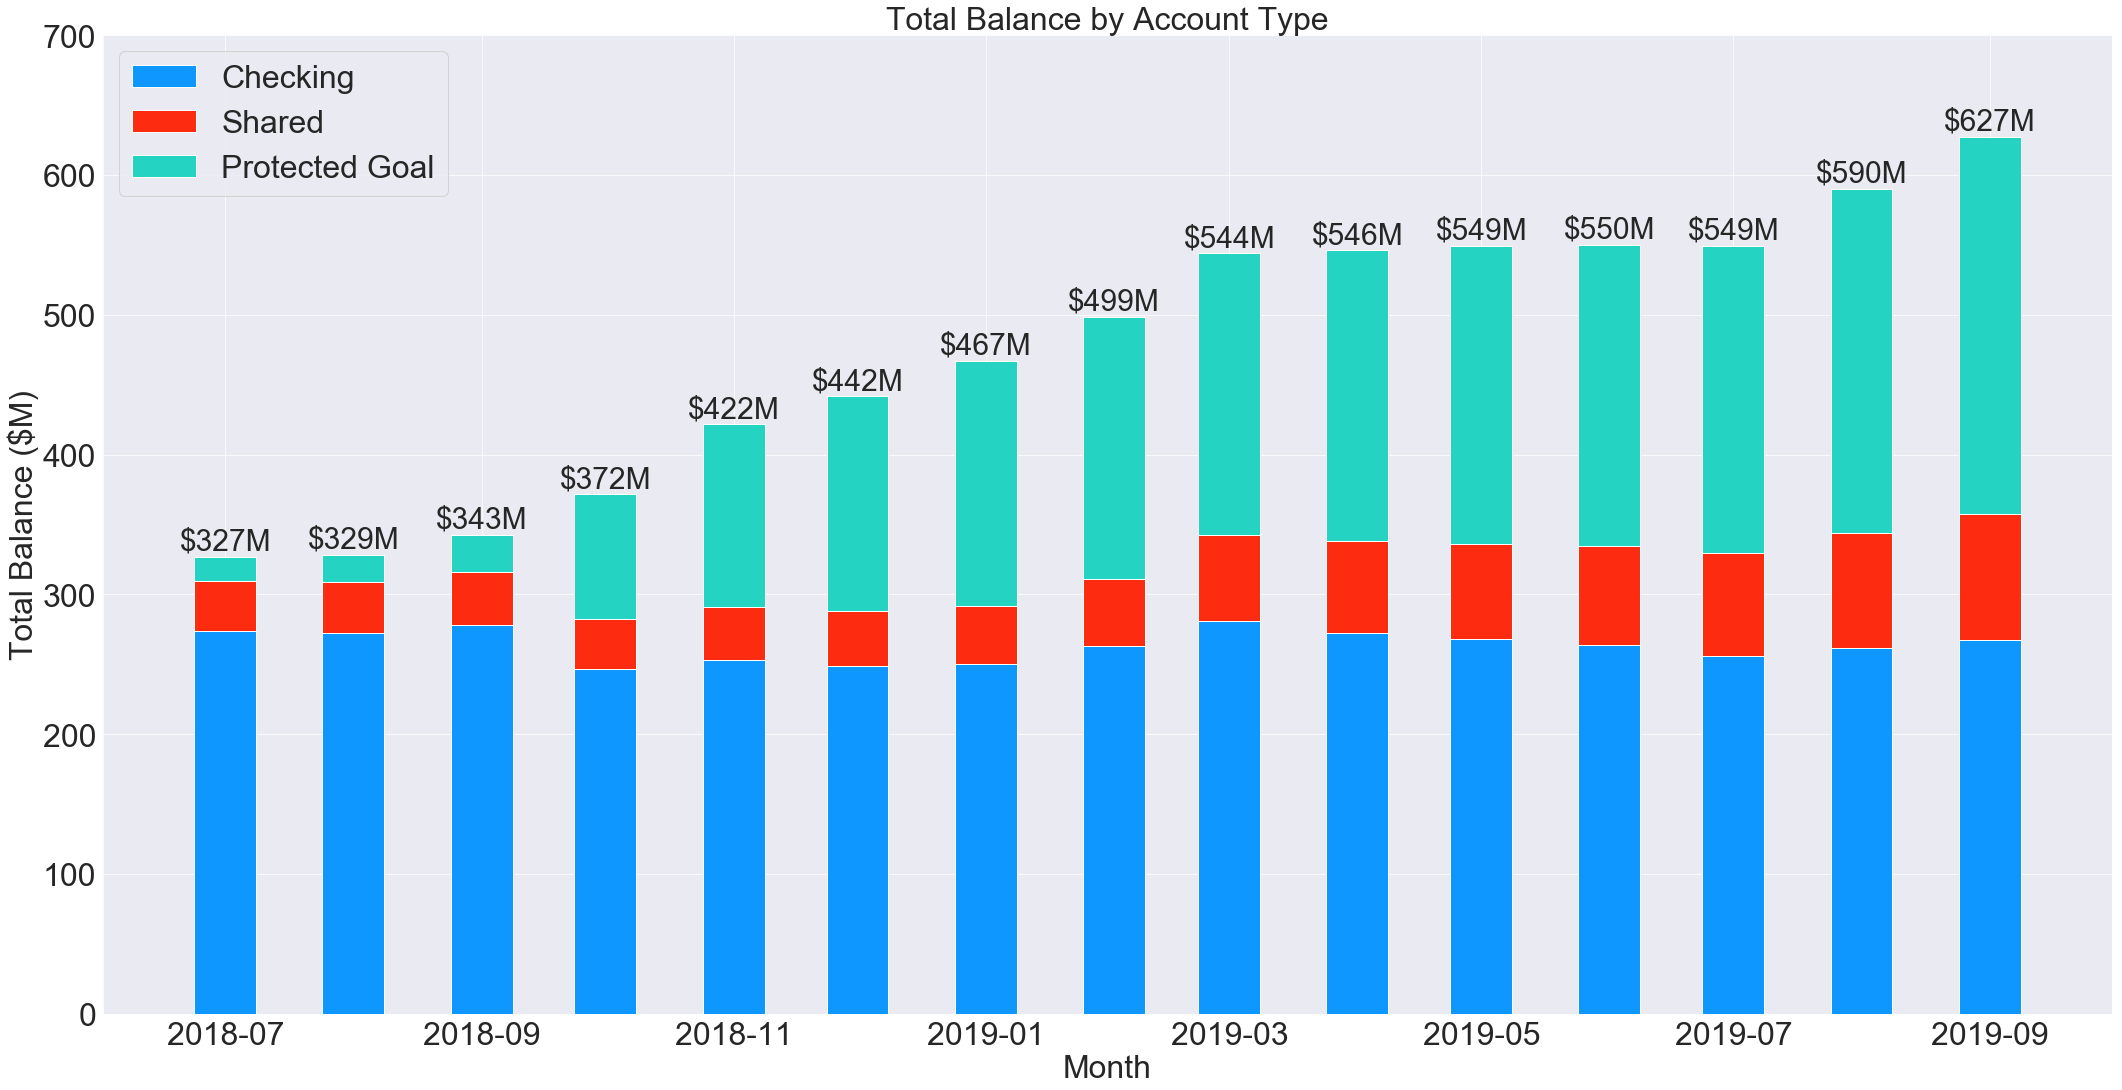

In [79]:
fig, ax = plt.subplots(figsize=(36,18))
months = total_checking.month
months2 = total_protected.month

width = 15
p1 = plt.bar(months, total_checking.total_balance_millions, width)
p2 = plt.bar(months, total_shared.total_balance_millions, width, bottom=total_checking.total_balance_millions)
p3 = plt.bar(months, total_protected.total_balance_millions, width, bottom=(total_checking[total_checking.month >= date(2017,10,1)].total_balance_millions+total_shared[total_shared.month >= date(2017,10,1)].total_balance_millions))

for m in total_checking.month:
#     print(datetime.date(m))
#     print(date(2017,10,1))
    height = 0
    height_protected = 0
    if datetime.date(m) >= date(2017,9,1): 
            m = datetime.date(m)
            height_protected = float(total_protected[total_protected.month == m].total_balance_millions)
    height =  float(total_checking[total_checking.month == m].total_balance_millions + total_shared[total_shared.month == m].total_balance_millions)     
    total_h = height_protected + height
    plt.text(m, 
             total_h+5, 
             '$'+str(round(float(total_h)))+'M',
            fontsize=30,
            ha='center')

plt.ylim(0,700)    
plt.xlabel('Month', fontsize = 32)
plt.xticks(fontsize = 32)
plt.ylabel('Total Balance ($M)', fontsize = 32)
plt.yticks(fontsize = 32)
plt.title('Total Balance by Account Type', fontsize = 32)
plt.legend(['Checking','Shared','Protected Goal'], fontsize=32)
plt.grid(True)

# The End